In [ ]:
# Data Overview
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

stings_df = pd.read_csv("GoldCoast\goaldcoast_stings.csv")
print(f"Dataset shape: {stings_df.shape}")
print(f"Date range: {stings_df['time'].min()} to {stings_df['time'].max()}")
print(f"Columns: {list(stings_df.columns)}")
print(f"\nData types:")
print(stings_df.dtypes)

print(f"\nBasic statistics:")
print(stings_df.describe())

print(f"\nMissing values:")
print(stings_df.isnull().sum())

print(f"\nBinary distribution:")
print(stings_df['stings_Binary'].value_counts())

print(f"\nSting count distribution:")
print(f"Min stings: {stings_df['stings_sum'].min()}")
print(f"Max stings: {stings_df['stings_sum'].max()}")
print(f"Mean stings: {stings_df['stings_sum'].mean():.2f}")
print(f"Days with stings >20: {(stings_df['stings_sum'] > 20).sum()}")

Dataset shape: (797, 3)
Date range: 1/01/2011 to 9/12/2023
Columns: ['time', 'stings_sum', 'stings_Binary']

Data types:
time             object
stings_sum        int64
stings_Binary     int64
dtype: object

Basic statistics:
        stings_sum  stings_Binary
count   797.000000     797.000000
mean     32.899624       0.284818
std     108.964184       0.451611
min       0.000000       0.000000
25%       0.000000       0.000000
50%       0.000000       0.000000
75%      24.000000       1.000000
max    1704.000000       1.000000

Missing values:
time             0
stings_sum       0
stings_Binary    0
dtype: int64

Binary distribution:
stings_Binary
0    570
1    227
Name: count, dtype: int64

Sting count distribution:
Min stings: 0
Max stings: 1704
Mean stings: 32.90
Days with stings >20: 220


In [ ]:
stings_df['date'] = pd.to_datetime(stings_df['time'], format='%d/%m/%Y')

stings_df = stings_df.sort_values('date').reset_index(drop=True)

env_data = np.load("GoldCoast/current_wind_20100101_20241231_GoaldCoast.npz")
uvts = env_data["UVTempSalt_UVTs"]

env_dates = pd.date_range("2010-01-01", periods=uvts.shape[0], freq="D")

overlap_start = max(stings_df['date'].min(), env_dates.min())
overlap_end = min(stings_df['date'].max(), env_dates.max())
print(f"Overlap period: {overlap_start} to {overlap_end}")

overlap_mask = (stings_df['date'] >= overlap_start) & (
    stings_df['date'] <= overlap_end)
stings_in_range = stings_df[overlap_mask]
print(
    f"\nSting observations in environmental data range: {len(stings_in_range)}")
print(
    f"Percentage of sting data usable: {len(stings_in_range)/len(stings_df)*100:.1f}%")

extreme_events = stings_in_range[stings_in_range['stings_sum'] > 100]
print(f"\nExtreme sting events (>100 stings): {len(extreme_events)}")
if len(extreme_events) > 0:
    print("Extreme event dates and counts:")
    print(extreme_events[['date', 'stings_sum']].head(10))

Overlap period: 2010-01-01 00:00:00 to 2024-12-31 00:00:00

Sting observations in environmental data range: 744
Percentage of sting data usable: 93.4%

Extreme sting events (>100 stings): 58
Extreme event dates and counts:
         date  stings_sum
41 2010-01-09         152
45 2010-01-26         112
50 2010-02-21         184
52 2010-03-07         118
77 2011-01-01         105
78 2011-01-02         358
79 2011-01-08         792
80 2011-01-09         826
87 2011-01-22         255
88 2011-01-23         252


In [ ]:
# spatial aggregation of environmental data
print("Creating spatial aggregates of environmental data...")

n_days, n_channels, n_lat, n_lon = uvts.shape

env_aggregated = {
    'date': env_dates,
    'u_current_mean': np.full(n_days, np.nan),
    'v_current_mean': np.full(n_days, np.nan),
    'current_speed_mean': np.full(n_days, np.nan),
    'sst_mean': np.full(n_days, np.nan),
    'salinity_mean': np.full(n_days, np.nan),
    'u_wind_mean': np.full(n_days, np.nan),
    'v_wind_mean': np.full(n_days, np.nan),
    'wind_speed_mean': np.full(n_days, np.nan),
    'sst_std': np.full(n_days, np.nan),
    'current_speed_std': np.full(n_days, np.nan),
    'wind_speed_std': np.full(n_days, np.nan)
}

for day in range(n_days):
    day_data = uvts[day]  
   
    u_current = day_data[0]  
    v_current = day_data[1]  
    sst = day_data[2]       
    salinity = day_data[3]   
    u_wind = day_data[4]     
    v_wind = day_data[5]     
    
    current_speed = np.sqrt(u_current**2 + v_current**2)
    wind_speed = np.sqrt(u_wind**2 + v_wind**2)
    
    env_aggregated['u_current_mean'][day] = np.nanmean(u_current)
    env_aggregated['v_current_mean'][day] = np.nanmean(v_current)
    env_aggregated['current_speed_mean'][day] = np.nanmean(current_speed)
    env_aggregated['sst_mean'][day] = np.nanmean(sst)
    env_aggregated['salinity_mean'][day] = np.nanmean(salinity)
    env_aggregated['u_wind_mean'][day] = np.nanmean(u_wind)
    env_aggregated['v_wind_mean'][day] = np.nanmean(v_wind)
    env_aggregated['wind_speed_mean'][day] = np.nanmean(wind_speed)
   
    env_aggregated['sst_std'][day] = np.nanstd(sst)
    env_aggregated['current_speed_std'][day] = np.nanstd(current_speed)
    env_aggregated['wind_speed_std'][day] = np.nanstd(wind_speed)


env_df = pd.DataFrame(env_aggregated)

print(f"Environmental dataset shape: {env_df.shape}")

print("\nMerging environmental and sting data...")
merged_df = pd.merge(stings_in_range, env_df, on='date', how='left')

print(f"Merged dataset shape: {merged_df.shape}")
print(
    f"Successful merges: {(~merged_df['sst_mean'].isna()).sum()} / {len(merged_df)}")

print(f"\nMissing values in merged dataset:")
missing_counts = merged_df.isnull().sum()
print(missing_counts[missing_counts > 0])

Creating spatial aggregates of environmental data...
Environmental dataset shape: (5479, 12)

Merging environmental and sting data...
Merged dataset shape: (744, 15)
Successful merges: 744 / 744

Missing values in merged dataset:
Series([], dtype: int64)


In [ ]:
# Correlation analysis
from scipy.stats import pearsonr, spearmanr
print("Correlation Analysis")

merged_df['month'] = merged_df['date'].dt.month
merged_df['day_of_year'] = merged_df['date'].dt.dayofyear
merged_df['year'] = merged_df['date'].dt.year

env_vars = [
    'sst_mean', 'salinity_mean', 'current_speed_mean', 'wind_speed_mean',
    'u_current_mean', 'v_current_mean', 'u_wind_mean', 'v_wind_mean',
    'sst_std', 'current_speed_std', 'wind_speed_std'
]

sting_vars = ['stings_sum', 'stings_Binary']

correlations = {}

for env_var in env_vars:
    corr_results = {}
    
    pearson_r, pearson_p = pearsonr(
        merged_df[env_var], merged_df['stings_sum'])
    
    spearman_r, spearman_p = spearmanr(
        merged_df[env_var], merged_df['stings_sum'])

   
    biserial_r, biserial_p = pearsonr(
        merged_df[env_var], merged_df['stings_Binary'])

    corr_results = {
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'biserial_r': biserial_r,
        'biserial_p': biserial_p
    }

    correlations[env_var] = corr_results
    print(f"\n{env_var.upper()}:")
    print(f"  Pearson (continuous):  r={pearson_r:6.3f}, p={pearson_p:.4f}")
    print(f"  Spearman (rank):       r={spearman_r:6.3f}, p={spearman_p:.4f}")
    print(f"  Binary correlation:    r={biserial_r:6.3f}, p={biserial_p:.4f}")

    
    sig_level = "***" if min(pearson_p, spearman_p, biserial_p) < 0.001 else "**" if min(pearson_p,
                                                                                         spearman_p, biserial_p) < 0.01 else "*" if min(pearson_p, spearman_p, biserial_p) < 0.05 else "ns"
    print(f"  Significance: {sig_level}")

correlation_summary = []
for env_var, results in correlations.items():
    correlation_summary.append({
        'variable': env_var,
        'pearson_r': results['pearson_r'],
        'abs_pearson': abs(results['pearson_r']),
        'p_value': results['pearson_p']
    })

correlation_summary.sort(key=lambda x: x['abs_pearson'], reverse=True)

print("Top 5 strongest correlations (by absolute Pearson r):")
for i, item in enumerate(correlation_summary[:5], 1):
    sig = "***" if item['p_value'] < 0.001 else "**" if item['p_value'] < 0.01 else "*" if item['p_value'] < 0.05 else "ns"
    print(f"{i}. {item['variable']:20s}: r = {item['pearson_r']:6.3f} {sig}")

sting_days = merged_df[merged_df['stings_Binary'] == 1]
no_sting_days = merged_df[merged_df['stings_Binary'] == 0]

print(f"Sting days: {len(sting_days)}")
print(f"No-sting days: {len(no_sting_days)}")

comparison_vars = ['sst_mean', 'current_speed_mean',
                   'wind_speed_mean', 'salinity_mean']

for var in comparison_vars:
    sting_mean = sting_days[var].mean()
    no_sting_mean = no_sting_days[var].mean()
    sting_std = sting_days[var].std()
    no_sting_std = no_sting_days[var].std()

    print(f"\n{var.upper()}:")
    print(f"  Sting days:    {sting_mean:7.3f} ± {sting_std:.3f}")
    print(f"  No-sting days: {no_sting_mean:7.3f} ± {no_sting_std:.3f}")
    print(f"  Difference:    {sting_mean - no_sting_mean:7.3f}")

Correlation Analysis

SST_MEAN:
  Pearson (continuous):  r= 0.165, p=0.0000
  Spearman (rank):       r= 0.336, p=0.0000
  Binary correlation:    r= 0.305, p=0.0000
  Significance: ***

SALINITY_MEAN:
  Pearson (continuous):  r=-0.068, p=0.0652
  Spearman (rank):       r=-0.080, p=0.0287
  Binary correlation:    r=-0.046, p=0.2090
  Significance: *

CURRENT_SPEED_MEAN:
  Pearson (continuous):  r= 0.103, p=0.0050
  Spearman (rank):       r= 0.230, p=0.0000
  Binary correlation:    r= 0.214, p=0.0000
  Significance: ***

WIND_SPEED_MEAN:
  Pearson (continuous):  r= 0.087, p=0.0178
  Spearman (rank):       r=-0.024, p=0.5154
  Binary correlation:    r=-0.029, p=0.4343
  Significance: *

U_CURRENT_MEAN:
  Pearson (continuous):  r=-0.089, p=0.0157
  Spearman (rank):       r=-0.065, p=0.0752
  Binary correlation:    r=-0.053, p=0.1475
  Significance: *

V_CURRENT_MEAN:
  Pearson (continuous):  r=-0.054, p=0.1407
  Spearman (rank):       r=-0.214, p=0.0000
  Binary correlation:    r=-0.207, p=

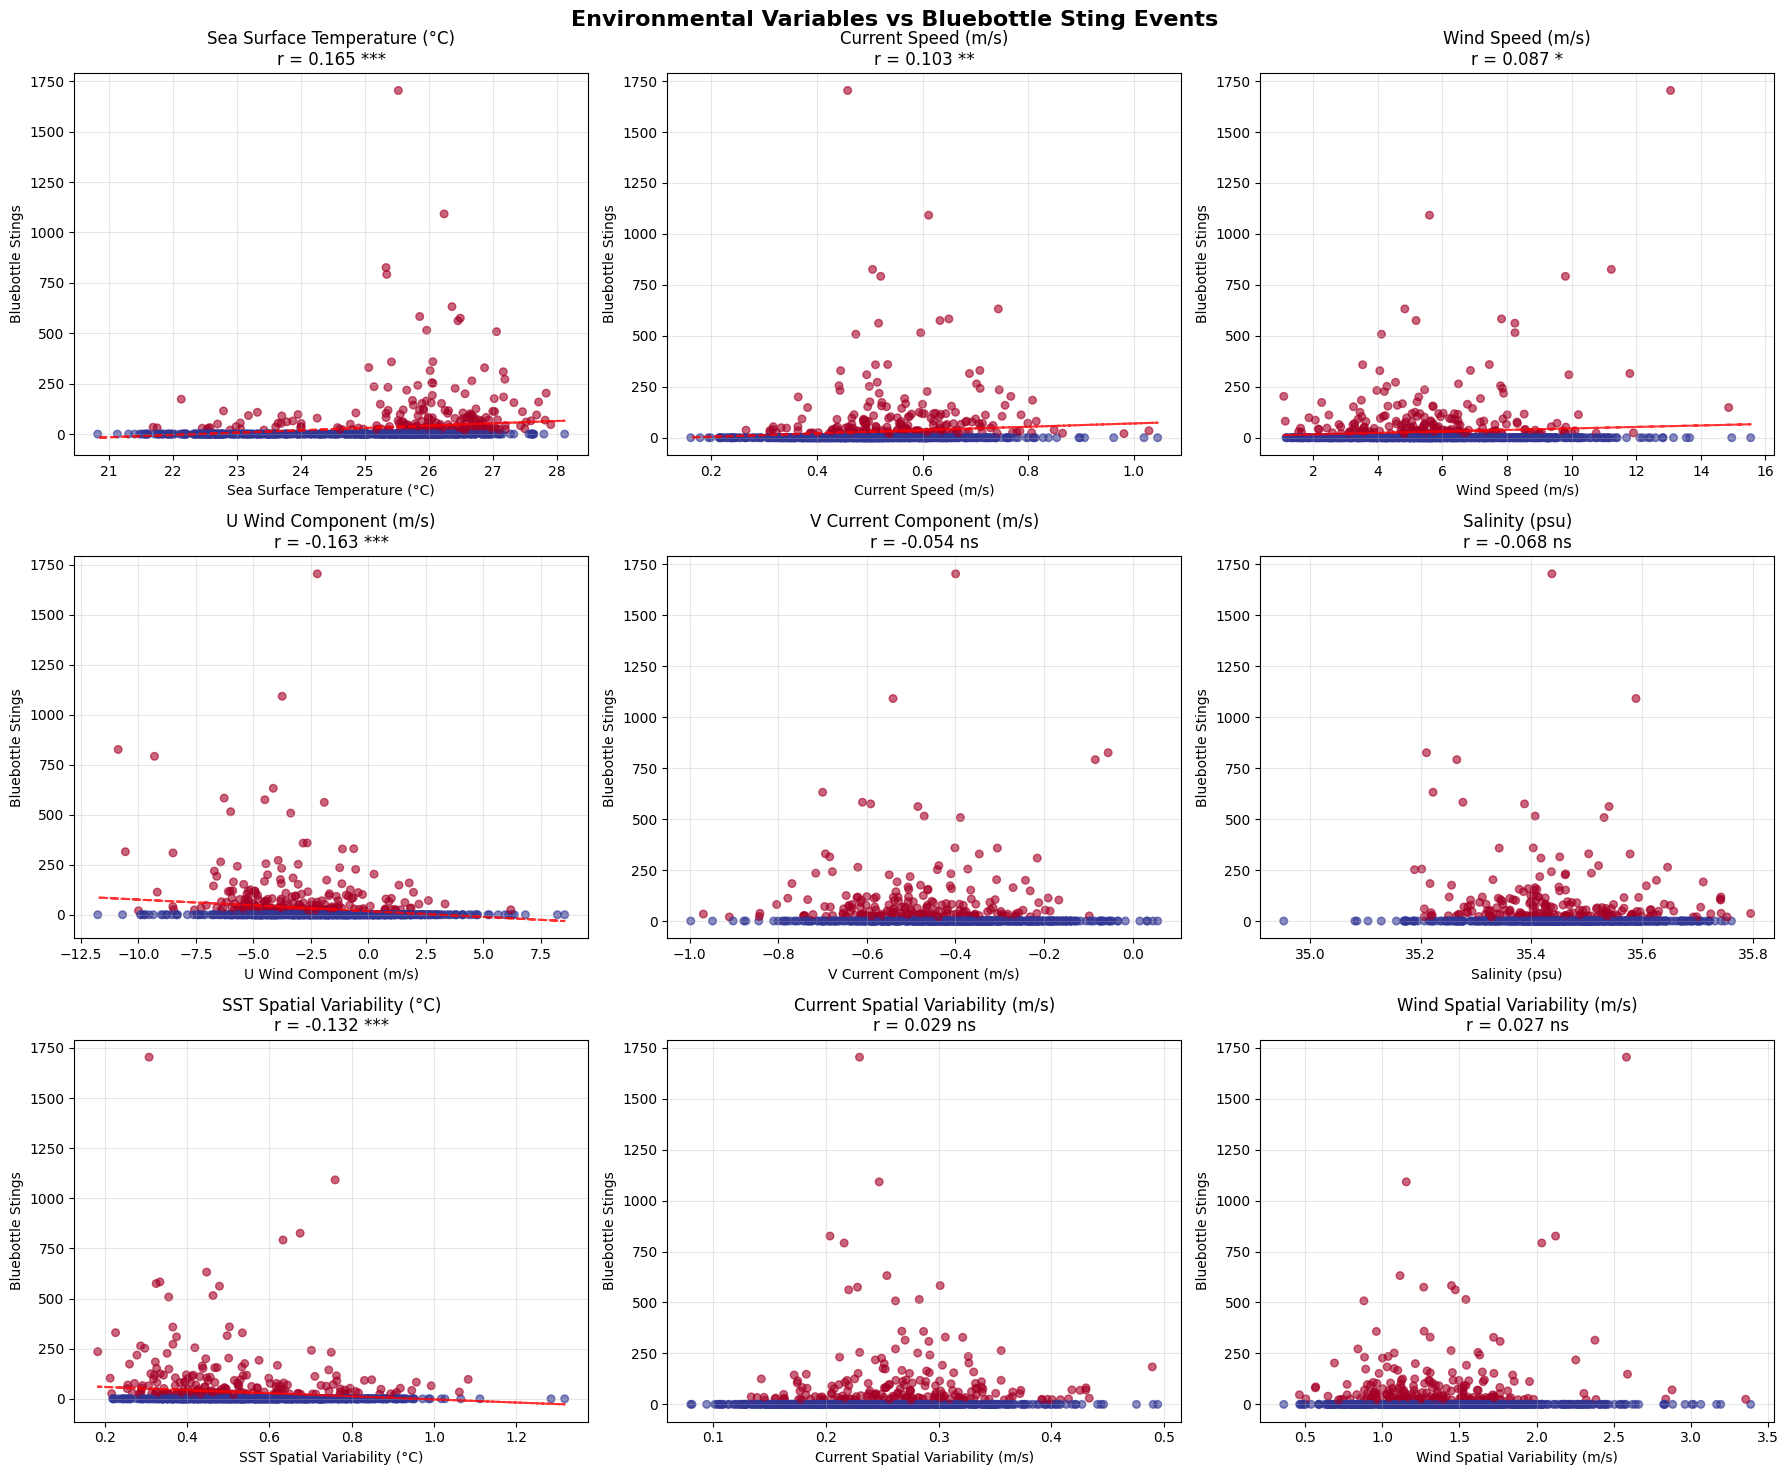


Analyzing temporal patterns...
Monthly Patterns:
Month  Days  Total   Mean   Prob    SST   Curr   Wind
        Obs Stings Stings  Sting   (°C)  (m/s)  (m/s)
--------------------------------------------------
    1   129  13269  102.9  0.543   26.2  0.598    6.3
    2    71   3112   43.8  0.549   26.6  0.549    6.6
    3   101   2141   21.2  0.307   26.3  0.528    5.6
    4   123    352    2.9  0.041   25.3  0.419    5.6
    9    32      0    0.0  0.000   22.1  0.465    5.4
   10   102    652    6.4  0.118   22.6  0.521    5.8
   11    82    394    4.8  0.098   23.8  0.491    5.9
   12   104   2814   27.1  0.327   25.2  0.527    6.2


Seasonal Analysis:
Season Days Total_Stings Mean_Stings Sting_Probability Mean_SST Mean_Current
Summer  304        19195        63.1             0.470   25.9°C     0.562m/s
Autumn  224         2493        11.1             0.161   25.8°C     0.468m/s
Spring  216         1046         4.8             0.093   23.0°C     0.501m/s


In [ ]:
# Statistical tests
from scipy.stats import kruskal, chi2_contingency


fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Environmental Variables vs Bluebottle Sting Events',
             fontsize=16, fontweight='bold')


plot_vars = [
    ('sst_mean', 'Sea Surface Temperature (°C)', 'red'),
    ('current_speed_mean', 'Current Speed (m/s)', 'blue'),
    ('wind_speed_mean', 'Wind Speed (m/s)', 'green'),
    ('u_wind_mean', 'U Wind Component (m/s)', 'orange'),
    ('v_current_mean', 'V Current Component (m/s)', 'purple'),
    ('salinity_mean', 'Salinity (psu)', 'brown'),
    ('sst_std', 'SST Spatial Variability (°C)', 'pink'),
    ('current_speed_std', 'Current Spatial Variability (m/s)', 'cyan'),
    ('wind_speed_std', 'Wind Spatial Variability (m/s)', 'gray')
]

for idx, (var, title, color) in enumerate(plot_vars):
    ax = axes[idx//3, idx % 3]

    
    scatter = ax.scatter(merged_df[var], merged_df['stings_sum'],
                         c=merged_df['stings_Binary'], cmap='RdYlBu_r',
                         alpha=0.6, s=30)

    
    corr_r = correlations[var]['pearson_r']
    corr_p = correlations[var]['pearson_p']
    sig = "***" if corr_p < 0.001 else "**" if corr_p < 0.01 else "*" if corr_p < 0.05 else "ns"

    ax.set_xlabel(title)
    ax.set_ylabel('Bluebottle Stings')
    ax.set_title(f'{title}\nr = {corr_r:.3f} {sig}')
    ax.grid(True, alpha=0.3)

    
    if corr_p < 0.05:
        z = np.polyfit(merged_df[var], merged_df['stings_sum'], 1)
        p = np.poly1d(z)
        ax.plot(merged_df[var], p(merged_df[var]),
                color='red', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()


print("\nAnalyzing temporal patterns...")


monthly_analysis = merged_df.groupby('month').agg({
    'stings_sum': ['count', 'sum', 'mean', 'std'],
    'stings_Binary': ['sum', 'mean'],
    'sst_mean': 'mean',
    'current_speed_mean': 'mean',
    'wind_speed_mean': 'mean'
}).round(3)


monthly_analysis.columns = ['_'.join(col).strip()
                            for col in monthly_analysis.columns]

print("Monthly Patterns:")
print("="*100)
print(f"{'Month':>5} {'Days':>5} {'Total':>6} {'Mean':>6} {'Prob':>6} {'SST':>6} {'Curr':>6} {'Wind':>6}")
print(f"{'':>5} {'Obs':>5} {'Stings':>6} {'Stings':>6} {'Sting':>6} {'(°C)':>6} {'(m/s)':>6} {'(m/s)':>6}")
print("-"*50)

for month in range(1, 13):
    if month in monthly_analysis.index:
        row = monthly_analysis.loc[month]
        print(f"{month:>5} {row['stings_sum_count']:>5.0f} {row['stings_sum_sum']:>6.0f} "
              f"{row['stings_sum_mean']:>6.1f} {row['stings_Binary_mean']:>6.3f} "
              f"{row['sst_mean_mean']:>6.1f} {row['current_speed_mean_mean']:>6.3f} "
              f"{row['wind_speed_mean_mean']:>6.1f}")


merged_df['season'] = merged_df['month'].map({
    12: 'Summer', 1: 'Summer', 2: 'Summer',
    3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
    6: 'Winter', 7: 'Winter', 8: 'Winter',
    9: 'Spring', 10: 'Spring', 11: 'Spring'
})

seasonal_analysis = merged_df.groupby('season').agg({
    'stings_sum': ['count', 'sum', 'mean', 'std'],
    'stings_Binary': ['sum', 'mean'],
    'sst_mean': ['mean', 'std'],
    'current_speed_mean': ['mean', 'std'],
    'wind_speed_mean': ['mean', 'std']
}).round(3)

print(f"\n\nSeasonal Analysis:")
print("="*80)
seasonal_summary = []
for season in ['Summer', 'Autumn', 'Winter', 'Spring']:
    if season in seasonal_analysis.index:
        row = seasonal_analysis.loc[season]
        seasonal_summary.append({
            'Season': season,
            'Days': f"{row[('stings_sum', 'count')]:.0f}",
            'Total_Stings': f"{row[('stings_sum', 'sum')]:.0f}",
            'Mean_Stings': f"{row[('stings_sum', 'mean')]:.1f}",
            'Sting_Probability': f"{row[('stings_Binary', 'mean')]:.3f}",
            'Mean_SST': f"{row[('sst_mean', 'mean')]:.1f}°C",
            'Mean_Current': f"{row[('current_speed_mean', 'mean')]:.3f}m/s"
        })

seasonal_df = pd.DataFrame(seasonal_summary)
print(seasonal_df.to_string(index=False))

Analyzing extreme bluebottle events...
Extreme event thresholds:
  90th percentile: 244 stings
  99th percentile: 831 stings

Extreme event analysis:
  Extreme events (90th percentile): 20
  Severe events (99th percentile): 2

Environmental conditions during extreme events:
SST MEAN:
  Normal days:    24.992 ± 1.563
  Extreme days:   26.154 ± 0.632
  Difference:      1.162
  T-test p:      0.0010 ***

CURRENT SPEED MEAN:
  Normal days:     0.515 ± 0.138
  Extreme days:    0.563 ± 0.096
  Difference:      0.048
  T-test p:      0.1266 ns

WIND SPEED MEAN:
  Normal days:     5.904 ± 2.562
  Extreme days:    7.247 ± 2.810
  Difference:      1.343
  T-test p:      0.0214 *

U WIND MEAN:
  Normal days:    -2.118 ± 3.048
  Extreme days:   -4.823 ± 3.008
  Difference:     -2.705
  T-test p:      0.0001 ***

V CURRENT MEAN:
  Normal days:    -0.425 ± 0.175
  Extreme days:   -0.442 ± 0.185
  Difference:     -0.017
  T-test p:      0.6738 ns

SALINITY MEAN:
  Normal days:    35.459 ± 0.126
  Ext

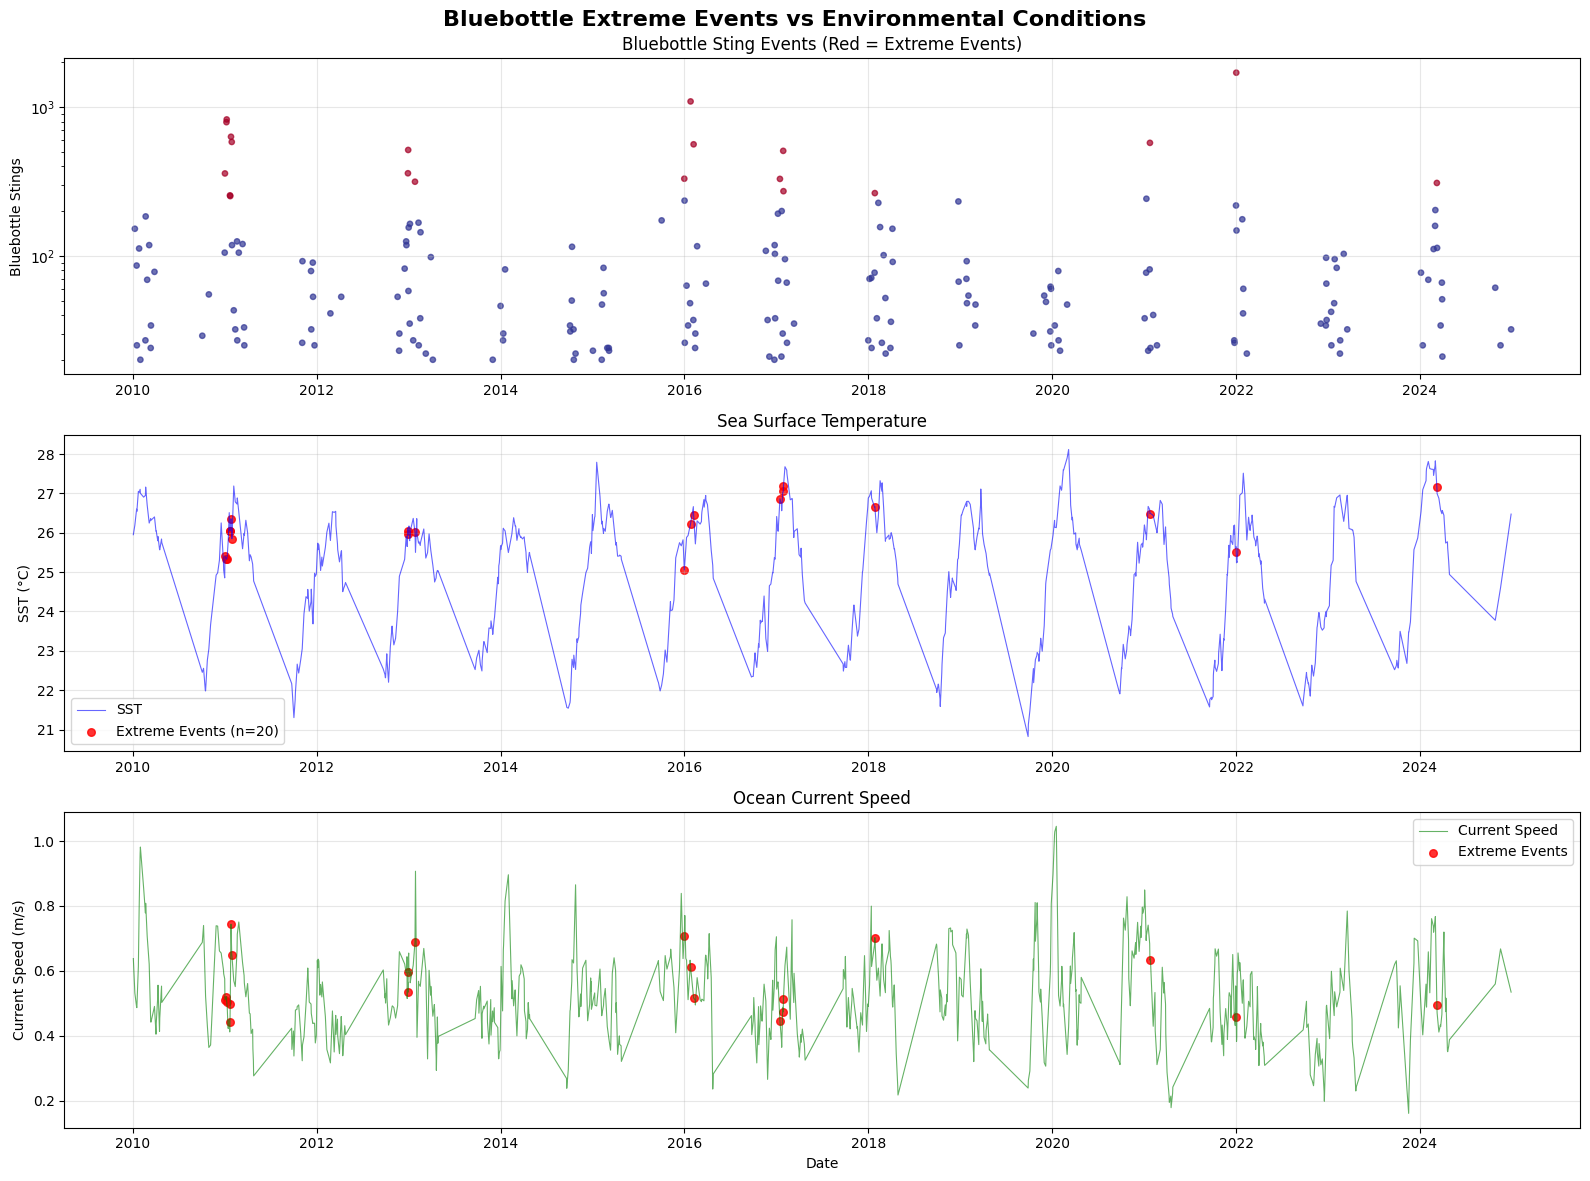

Analyzing lag correlations (environmental conditions preceding sting events)...

Lag 1 days:
  sst_mean            : r =  0.167, p = 0.0000
  current_speed_mean  : r =  0.115, p = 0.0017
  wind_speed_mean     : r =  0.010, p = 0.7879
  u_wind_mean         : r = -0.111, p = 0.0025

Lag 2 days:
  sst_mean            : r =  0.154, p = 0.0000
  current_speed_mean  : r =  0.130, p = 0.0004
  wind_speed_mean     : r = -0.010, p = 0.7945
  u_wind_mean         : r = -0.077, p = 0.0371

Lag 3 days:
  sst_mean            : r =  0.136, p = 0.0002
  current_speed_mean  : r =  0.118, p = 0.0012
  wind_speed_mean     : r =  0.060, p = 0.1010
  u_wind_mean         : r = -0.131, p = 0.0003

Lag 7 days:
  sst_mean            : r =  0.091, p = 0.0131
  current_speed_mean  : r =  0.111, p = 0.0026
  wind_speed_mean     : r = -0.000, p = 0.9996
  u_wind_mean         : r = -0.050, p = 0.1783


In [ ]:
# Statistical tests for seasonal differences
print("Analyzing extreme bluebottle events...")


sting_threshold_95 = merged_df[merged_df['stings_sum']
                               > 0]['stings_sum'].quantile(0.90)
sting_threshold_99 = merged_df[merged_df['stings_sum']
                               > 0]['stings_sum'].quantile(0.99)

print(f"Extreme event thresholds:")
print(f"  90th percentile: {sting_threshold_95:.0f} stings")
print(f"  99th percentile: {sting_threshold_99:.0f} stings")


merged_df['extreme_event'] = (
    merged_df['stings_sum'] >= sting_threshold_95).astype(int)
merged_df['severe_event'] = (
    merged_df['stings_sum'] >= sting_threshold_99).astype(int)

extreme_events = merged_df[merged_df['extreme_event'] == 1]
severe_events = merged_df[merged_df['severe_event'] == 1]

print(f"\nExtreme event analysis:")
print(f"  Extreme events (90th percentile): {len(extreme_events)}")
print(f"  Severe events (99th percentile): {len(severe_events)}")

print(f"\nEnvironmental conditions during extreme events:")
print("="*70)

normal_days = merged_df[merged_df['extreme_event'] == 0]
extreme_days = merged_df[merged_df['extreme_event'] == 1]

comparison_vars = ['sst_mean', 'current_speed_mean', 'wind_speed_mean', 'u_wind_mean',
                   'v_current_mean', 'salinity_mean', 'sst_std']

for var in comparison_vars:
    normal_mean = normal_days[var].mean()
    extreme_mean = extreme_days[var].mean()
    normal_std = normal_days[var].std()
    extreme_std = extreme_days[var].std()

    
    from scipy.stats import ttest_ind
    t_stat, t_p = ttest_ind(normal_days[var], extreme_days[var])

    print(f"{var.upper().replace('_', ' ')}:")
    print(f"  Normal days:   {normal_mean:7.3f} ± {normal_std:.3f}")
    print(f"  Extreme days:  {extreme_mean:7.3f} ± {extreme_std:.3f}")
    print(f"  Difference:    {extreme_mean - normal_mean:7.3f}")
    print(
        f"  T-test p:      {t_p:.4f} {'***' if t_p < 0.001 else '**' if t_p < 0.01 else '*' if t_p < 0.05 else 'ns'}")
    print()


print("Creating extreme event timeline...")

fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Bluebottle Extreme Events vs Environmental Conditions',
             fontsize=16, fontweight='bold')


ax1 = axes[0]
ax1.scatter(merged_df['date'], merged_df['stings_sum'],
            c=merged_df['extreme_event'], cmap='RdYlBu_r', alpha=0.7, s=15)
ax1.set_ylabel('Bluebottle Stings')
ax1.set_title('Bluebottle Sting Events (Red = Extreme Events)')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')


ax2 = axes[1]
ax2.plot(merged_df['date'], merged_df['sst_mean'],
         'b-', alpha=0.6, linewidth=0.8, label='SST')
extreme_sst = merged_df[merged_df['extreme_event'] == 1]
ax2.scatter(extreme_sst['date'], extreme_sst['sst_mean'],
            color='red', s=30, alpha=0.8, label=f'Extreme Events (n={len(extreme_sst)})')
ax2.set_ylabel('SST (°C)')
ax2.set_title('Sea Surface Temperature')
ax2.legend()
ax2.grid(True, alpha=0.3)


ax3 = axes[2]
ax3.plot(merged_df['date'], merged_df['current_speed_mean'],
         'g-', alpha=0.6, linewidth=0.8, label='Current Speed')
extreme_curr = merged_df[merged_df['extreme_event'] == 1]
ax3.scatter(extreme_curr['date'], extreme_curr['current_speed_mean'],
            color='red', s=30, alpha=0.8, label='Extreme Events')
ax3.set_ylabel('Current Speed (m/s)')
ax3.set_xlabel('Date')
ax3.set_title('Ocean Current Speed')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('extreme_events_timeline.png', dpi=300, bbox_inches='tight')
plt.show()


print("Analyzing lag correlations (environmental conditions preceding sting events)...")


lag_correlations = {}
lags_to_test = [1, 2, 3, 7]

for lag in lags_to_test:
    print(f"\nLag {lag} days:")
    lag_corrs = {}

    for var in ['sst_mean', 'current_speed_mean', 'wind_speed_mean', 'u_wind_mean']:
        lagged_env = merged_df[var].shift(lag)
        valid_indices = ~(lagged_env.isna() | merged_df['stings_sum'].isna())

        if valid_indices.sum() > 50:
            corr_r, corr_p = pearsonr(lagged_env[valid_indices],
                                      merged_df['stings_sum'][valid_indices])
            lag_corrs[var] = {'r': corr_r, 'p': corr_p}
            print(f"  {var:20s}: r = {corr_r:6.3f}, p = {corr_p:.4f}")

    lag

In [ ]:
# Correlation summary table
correlation_summary = pd.DataFrame({
    'Variable': [
        'SST (°C)', 'Current Speed (m/s)', 'U-Wind (m/s)', 'V-Current (m/s)',
        'Wind Speed (m/s)', 'Salinity (psu)', 'SST Variability',
        'Current Variability', 'Wind Variability'
    ],
    'Pearson_r': [
        correlations['sst_mean']['pearson_r'],
        correlations['current_speed_mean']['pearson_r'],
        correlations['u_wind_mean']['pearson_r'],
        correlations['v_current_mean']['pearson_r'],
        correlations['wind_speed_mean']['pearson_r'],
        correlations['salinity_mean']['pearson_r'],
        correlations['sst_std']['pearson_r'],
        correlations['current_speed_std']['pearson_r'],
        correlations['wind_speed_std']['pearson_r']
    ],
    'P_Value': [
        correlations['sst_mean']['pearson_p'],
        correlations['current_speed_mean']['pearson_p'],
        correlations['u_wind_mean']['pearson_p'],
        correlations['v_current_mean']['pearson_p'],
        correlations['wind_speed_mean']['pearson_p'],
        correlations['salinity_mean']['pearson_p'],
        correlations['sst_std']['pearson_p'],
        correlations['current_speed_std']['pearson_p'],
        correlations['wind_speed_std']['pearson_p']
    ],
    'Binary_r': [
        correlations['sst_mean']['biserial_r'],
        correlations['current_speed_mean']['biserial_r'],
        correlations['u_wind_mean']['biserial_r'],
        correlations['v_current_mean']['biserial_r'],
        correlations['wind_speed_mean']['biserial_r'],
        correlations['salinity_mean']['biserial_r'],
        correlations['sst_std']['biserial_r'],
        correlations['current_speed_std']['biserial_r'],
        correlations['wind_speed_std']['biserial_r']
    ]
})


correlation_summary['Significance'] = correlation_summary['P_Value'].apply(
    lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
)


correlation_summary['Abs_Correlation'] = correlation_summary['Pearson_r'].abs()
correlation_summary = correlation_summary.sort_values(
    'Abs_Correlation', ascending=False)

print("FINAL CORRELATION SUMMARY TABLE:")
print("="*90)
print(f"{'Variable':<20} {'Pearson_r':<10} {'Binary_r':<10} {'P_Value':<10} {'Significance':<12}")
print("-"*90)
for _, row in correlation_summary.iterrows():
    print(f"{row['Variable']:<20} {row['Pearson_r']:>9.3f} {row['Binary_r']:>9.3f} "
          f"{row['P_Value']:>9.4f} {row['Significance']:>11}")


print(f"\n" + "="*90)
print("BLUEBOTTLE RISK ASSESSMENT FRAMEWORK")
print("="*90)


def classify_risk(row):
    score = 0

    
    if row['sst_mean'] > 26.0:
        score += 3
    elif row['sst_mean'] > 25.0:
        score += 2
    elif row['sst_mean'] > 24.0:
        score += 1

    
    if row['u_wind_mean'] < -4.0:
        score += 2
    elif row['u_wind_mean'] < -2.0:
        score += 1
    elif row['u_wind_mean'] > 1.0:
        score -= 1

    
    if row['current_speed_mean'] > 0.6:
        score += 1
    elif row['current_speed_mean'] < 0.4:
        score -= 1

    
    if row['sst_std'] < 0.4:
        score += 1
    elif row['sst_std'] > 0.7:
        score -= 1

    
    month = row['date'].month
    if month in [1, 2]:  
        score += 2
    elif month in [12, 3]:  
        score += 1
    elif month in [9, 10]:  
        score -= 1

    return max(0, min(8, score))  



merged_df['risk_score'] = merged_df.apply(classify_risk, axis=1)


risk_validation = merged_df.groupby('risk_score').agg({
    'stings_Binary': ['count', 'sum', 'mean'],
    'stings_sum': ['mean', 'max']
}).round(3)

risk_validation.columns = ['Count', 'Sting_Days',
                           'Sting_Probability', 'Mean_Stings', 'Max_Stings']

print("Risk Score Validation:")
print(f"{'Score':<5} {'Days':<5} {'Sting_Days':<10} {'Probability':<11} {'Mean_Stings':<10} {'Max_Stings':<10}")
print("-"*55)
for score in range(9):
    if score in risk_validation.index:
        row = risk_validation.loc[score]
        print(f"{score:<5} {row['Count']:>4.0f} {row['Sting_Days']:>9.0f} "
              f"{row['Sting_Probability']:>10.3f} {row['Mean_Stings']:>9.1f} {row['Max_Stings']:>9.0f}")


high_risk_days = merged_df[merged_df['risk_score'] >= 6]
low_risk_days = merged_df[merged_df['risk_score'] <= 2]

print(f"\nRisk Score Performance:")
print(f"  High Risk Days (score 6-8): {len(high_risk_days)} days")
print(
    f"  High Risk Sting Probability: {high_risk_days['stings_Binary'].mean():.1%}")
print(f"  Low Risk Days (score 0-2): {len(low_risk_days)} days")
print(
    f"  Low Risk Sting Probability: {low_risk_days['stings_Binary'].mean():.1%}")
print(
    f"  Risk Discrimination: {high_risk_days['stings_Binary'].mean() / max(low_risk_days['stings_Binary'].mean(), 0.001):.1f}x higher")

FINAL CORRELATION SUMMARY TABLE:
Variable             Pearson_r  Binary_r   P_Value    Significance
------------------------------------------------------------------------------------------
SST (°C)                 0.165     0.305    0.0000         ***
U-Wind (m/s)            -0.163    -0.220    0.0000         ***
SST Variability         -0.132    -0.189    0.0003         ***
Current Speed (m/s)      0.103     0.214    0.0050          **
Wind Speed (m/s)         0.087    -0.029    0.0178           *
Salinity (psu)          -0.068    -0.046    0.0652          ns
V-Current (m/s)         -0.054    -0.207    0.1407          ns
Current Variability      0.029     0.109    0.4327          ns
Wind Variability         0.027    -0.090    0.4661          ns

BLUEBOTTLE RISK ASSESSMENT FRAMEWORK
Risk Score Validation:
Score Days  Sting_Days Probability Mean_Stings Max_Stings
-------------------------------------------------------
0      186        16      0.086       4.7       173
1       74     

Environmental Data Shape: (5479, 6, 15, 15)
Date Range: 2010-01-01 00:00:00 to 2024-12-31 00:00:00
Spatial Domain: 153.400°E to 154.870°E, -27.753°N to -29.200°N
Grid Resolution: 15x15 pixels

LOADING BLUEBOTTLE STING DATA
--------------------------------------------------
Bluebottle data shape: (797, 4)
Merged dataset shape: (744, 17)
Successful merges: 744 observations
Overlap period: 2010-01-01 00:00:00 to 2024-12-31 00:00:00

4. CREATING TIME SERIES VISUALIZATIONS
--------------------------------------------------


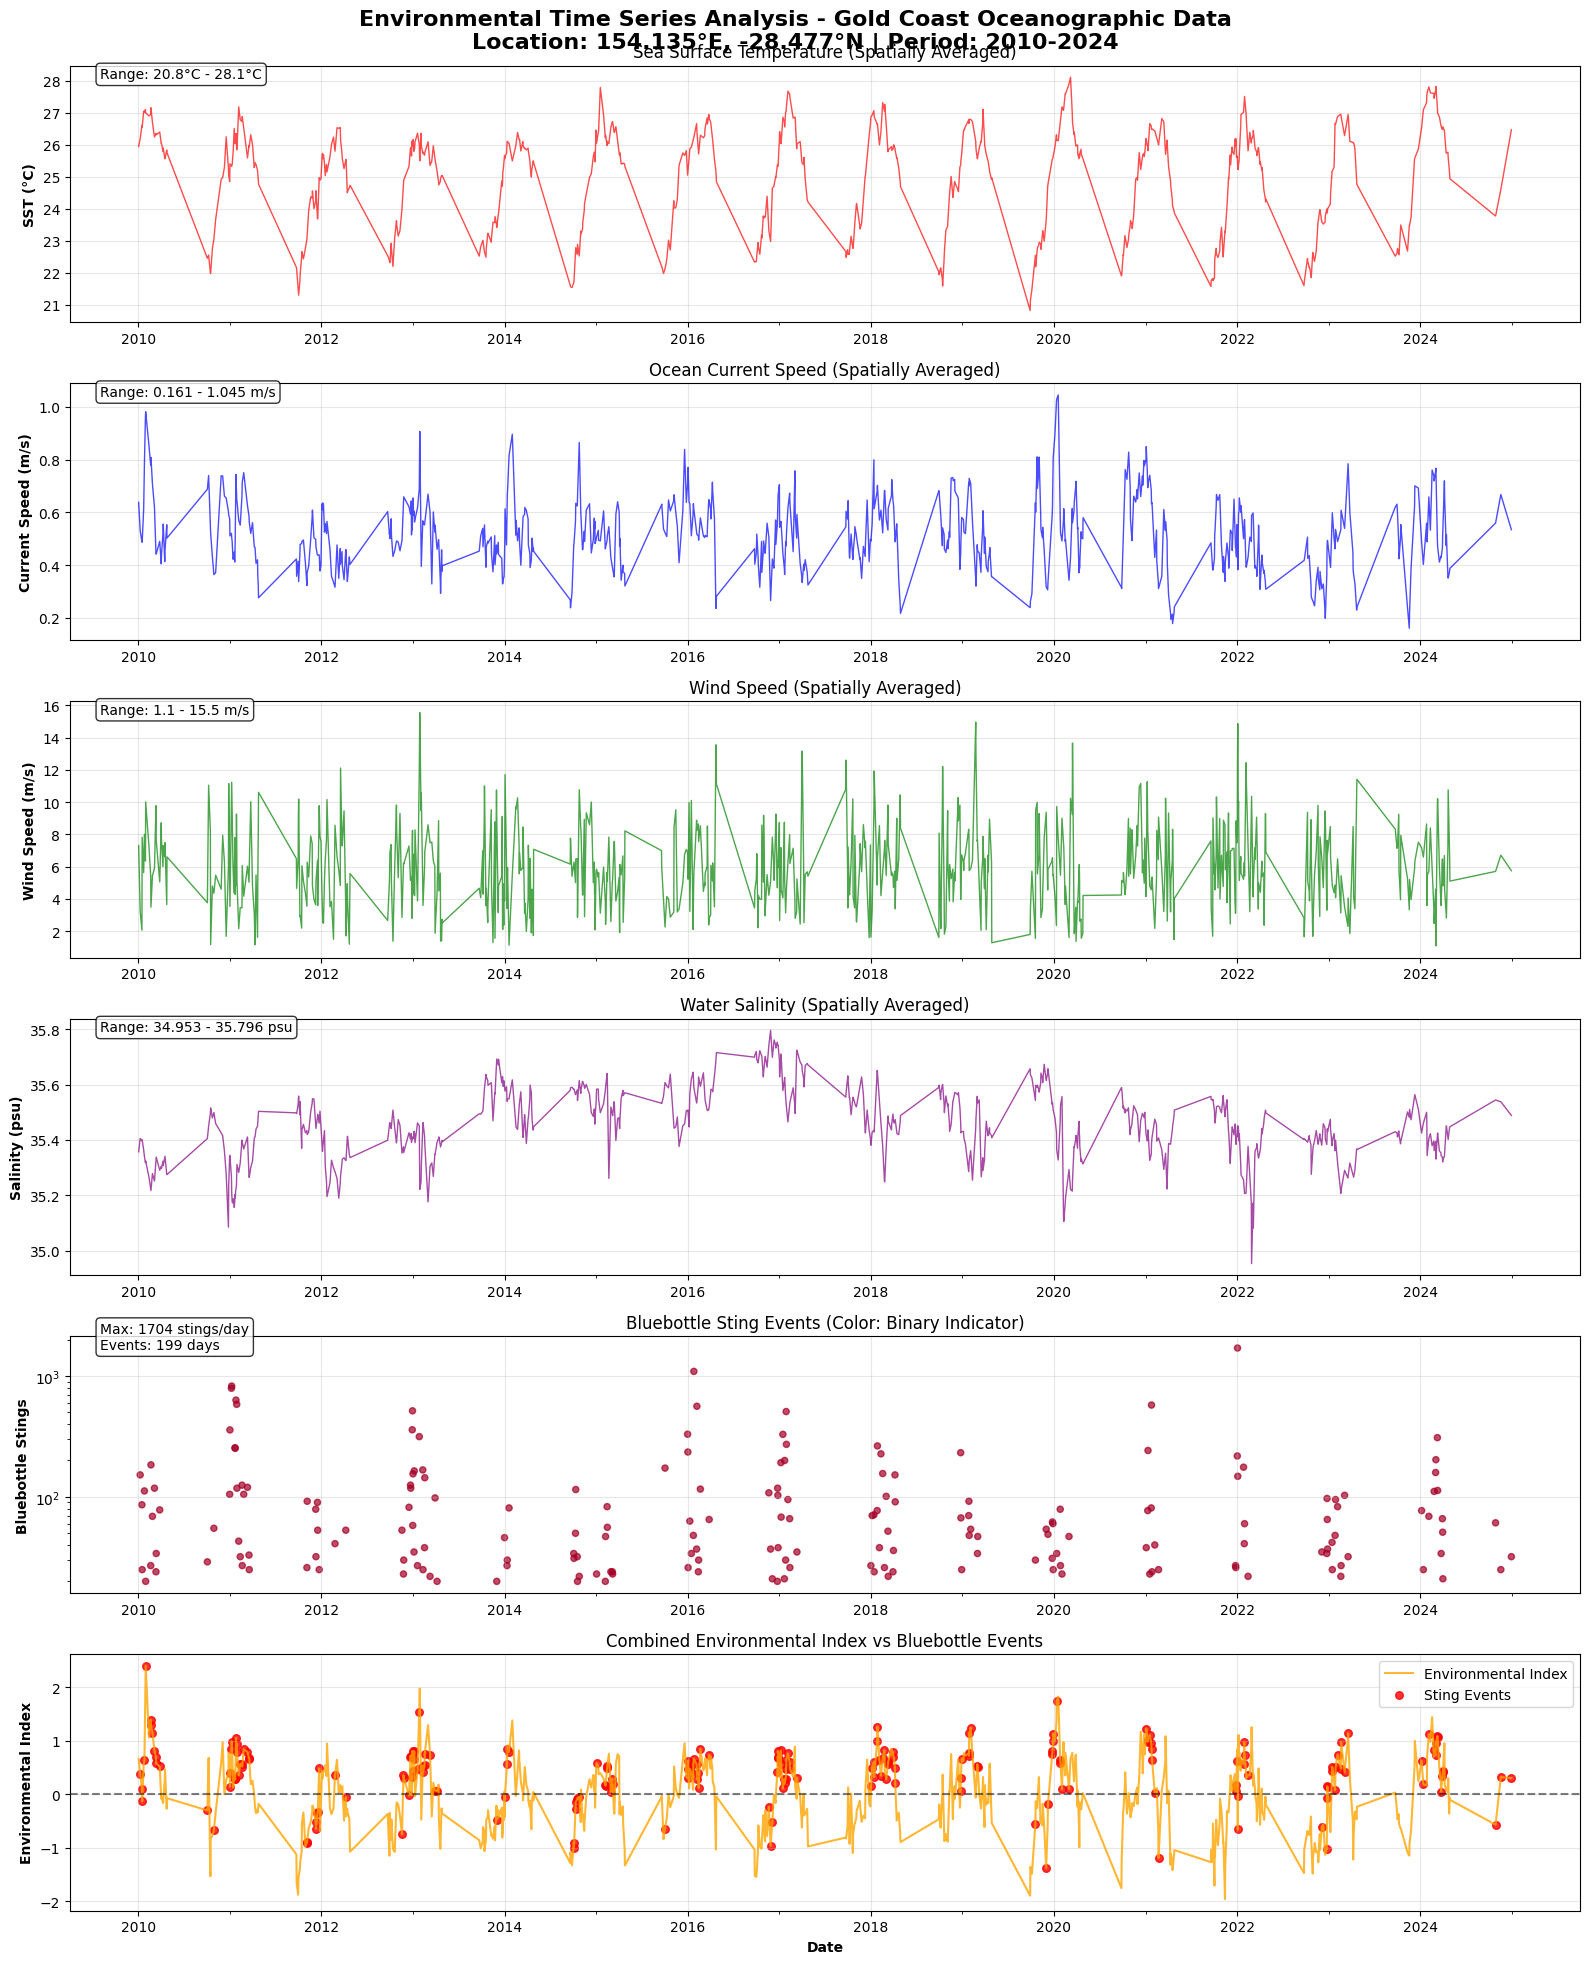


5. CREATING SPATIAL DISTRIBUTION MAPS
--------------------------------------------------


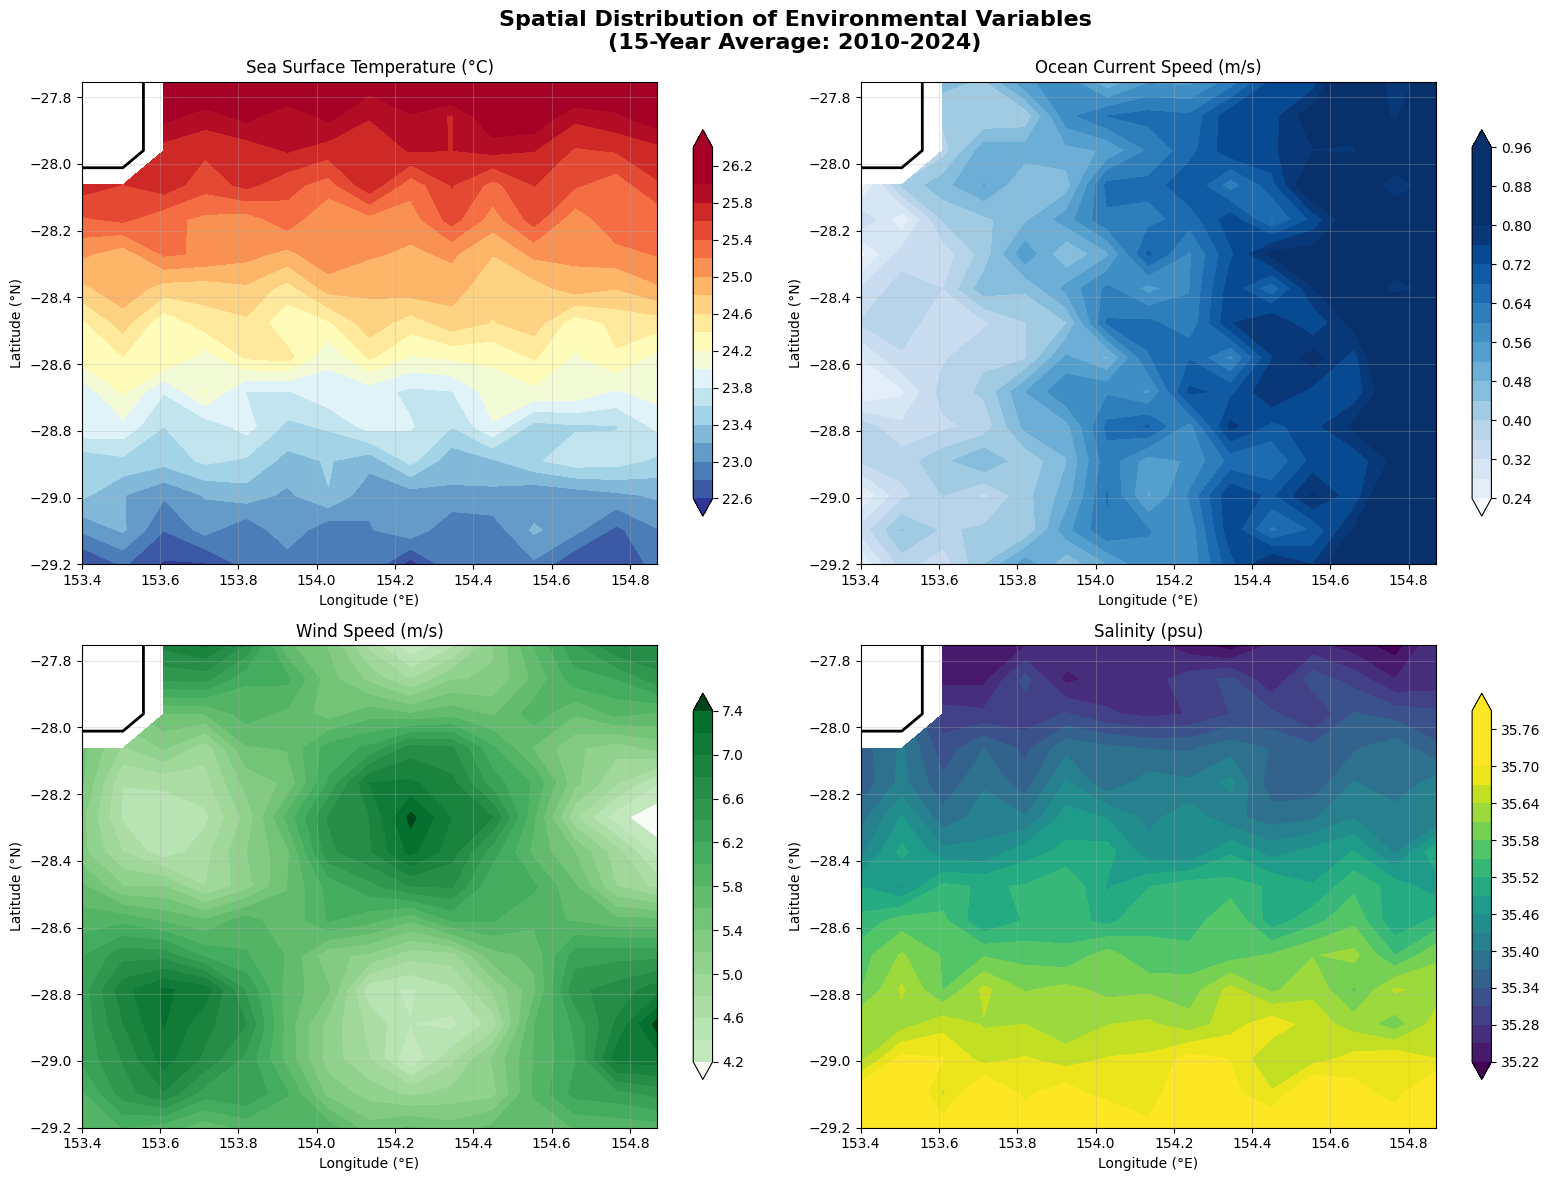


6. CREATING DISTRIBUTION ANALYSIS
--------------------------------------------------


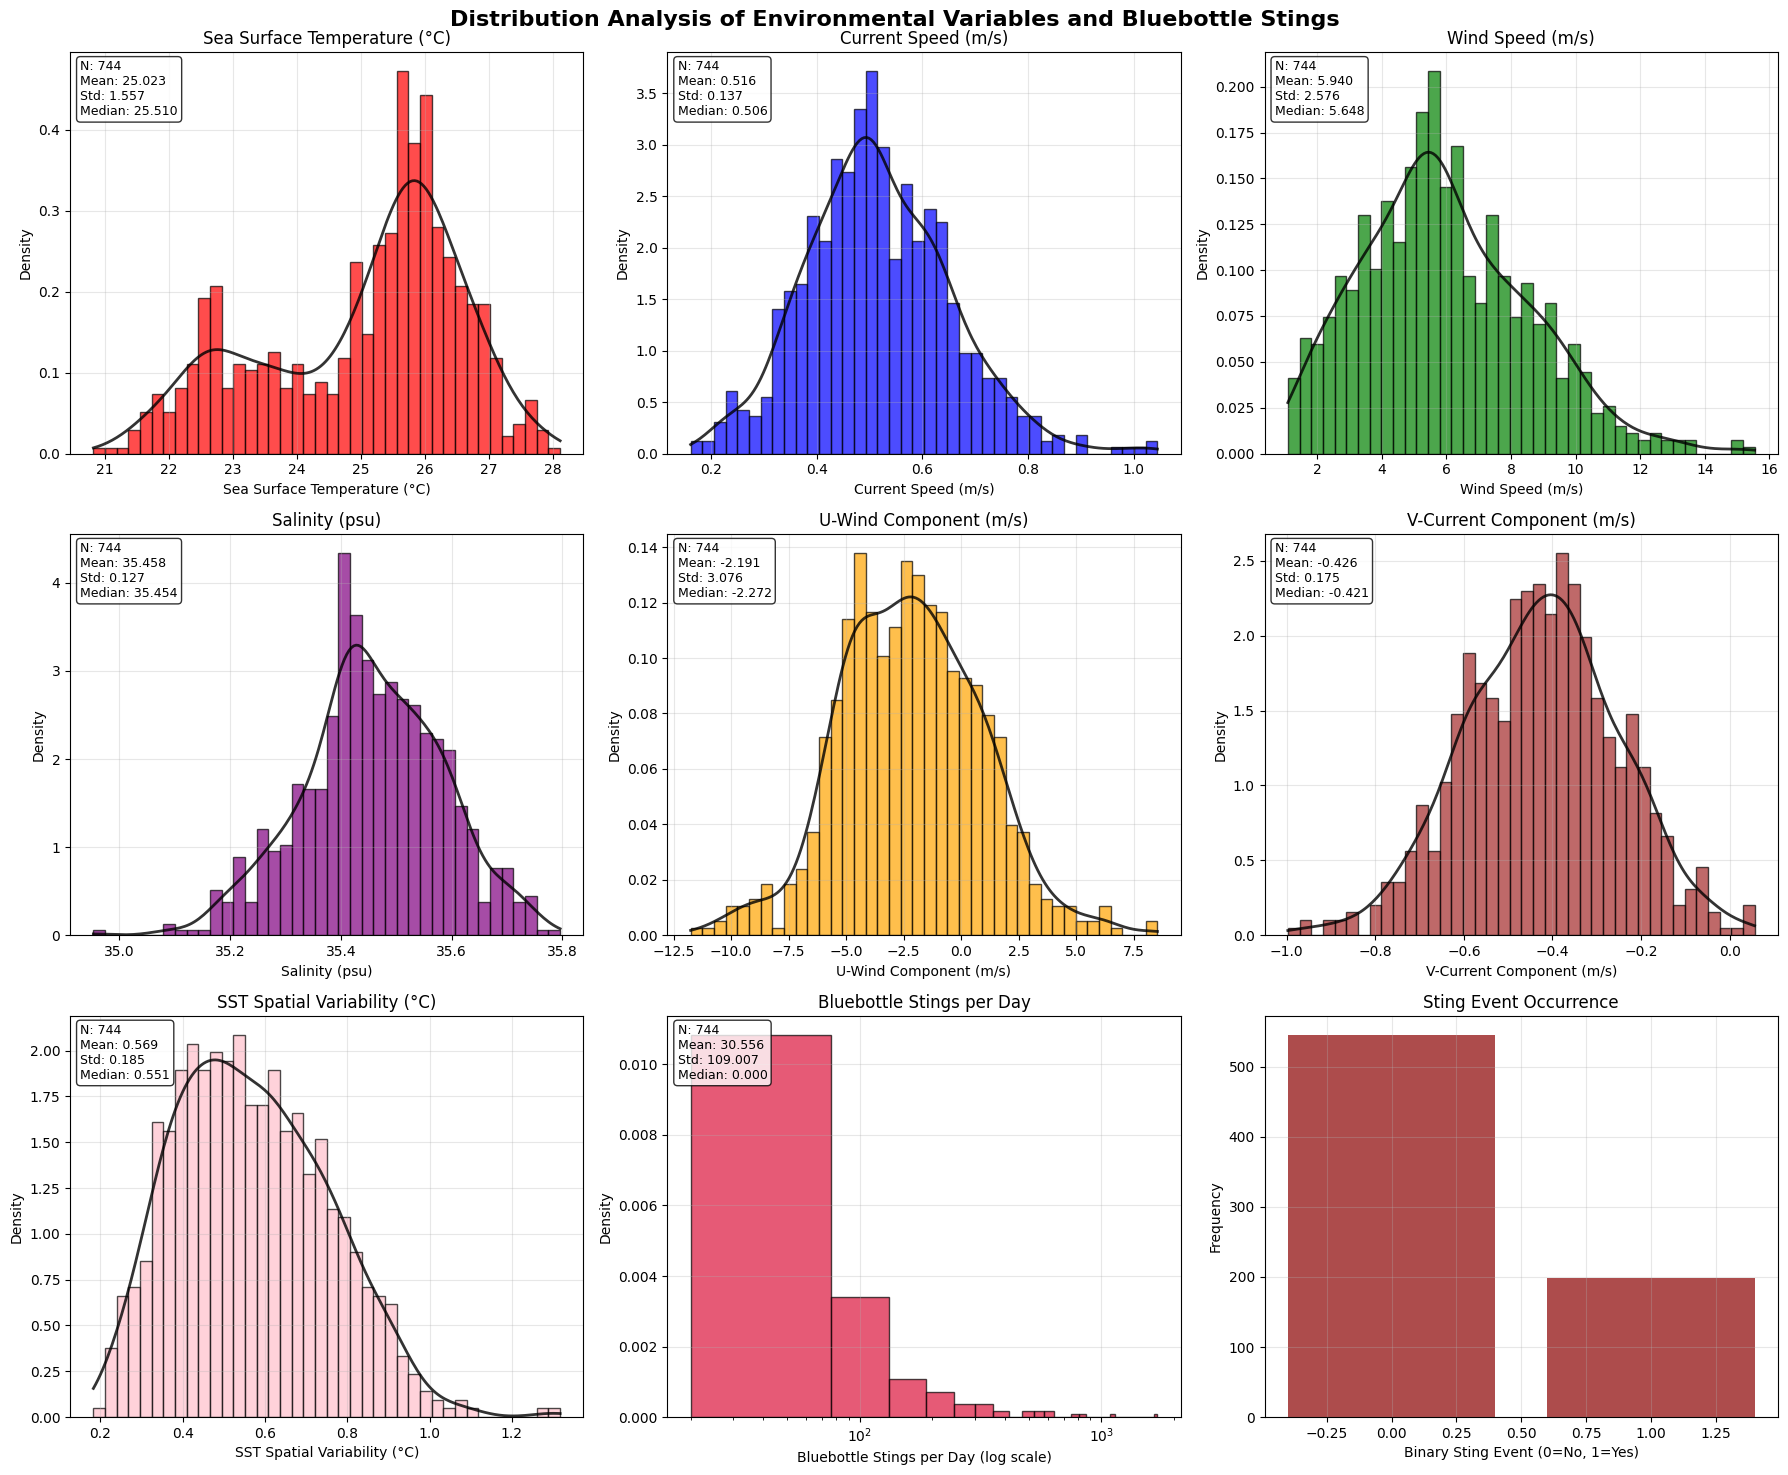


7. CREATING CORRELATION ANALYSIS
--------------------------------------------------


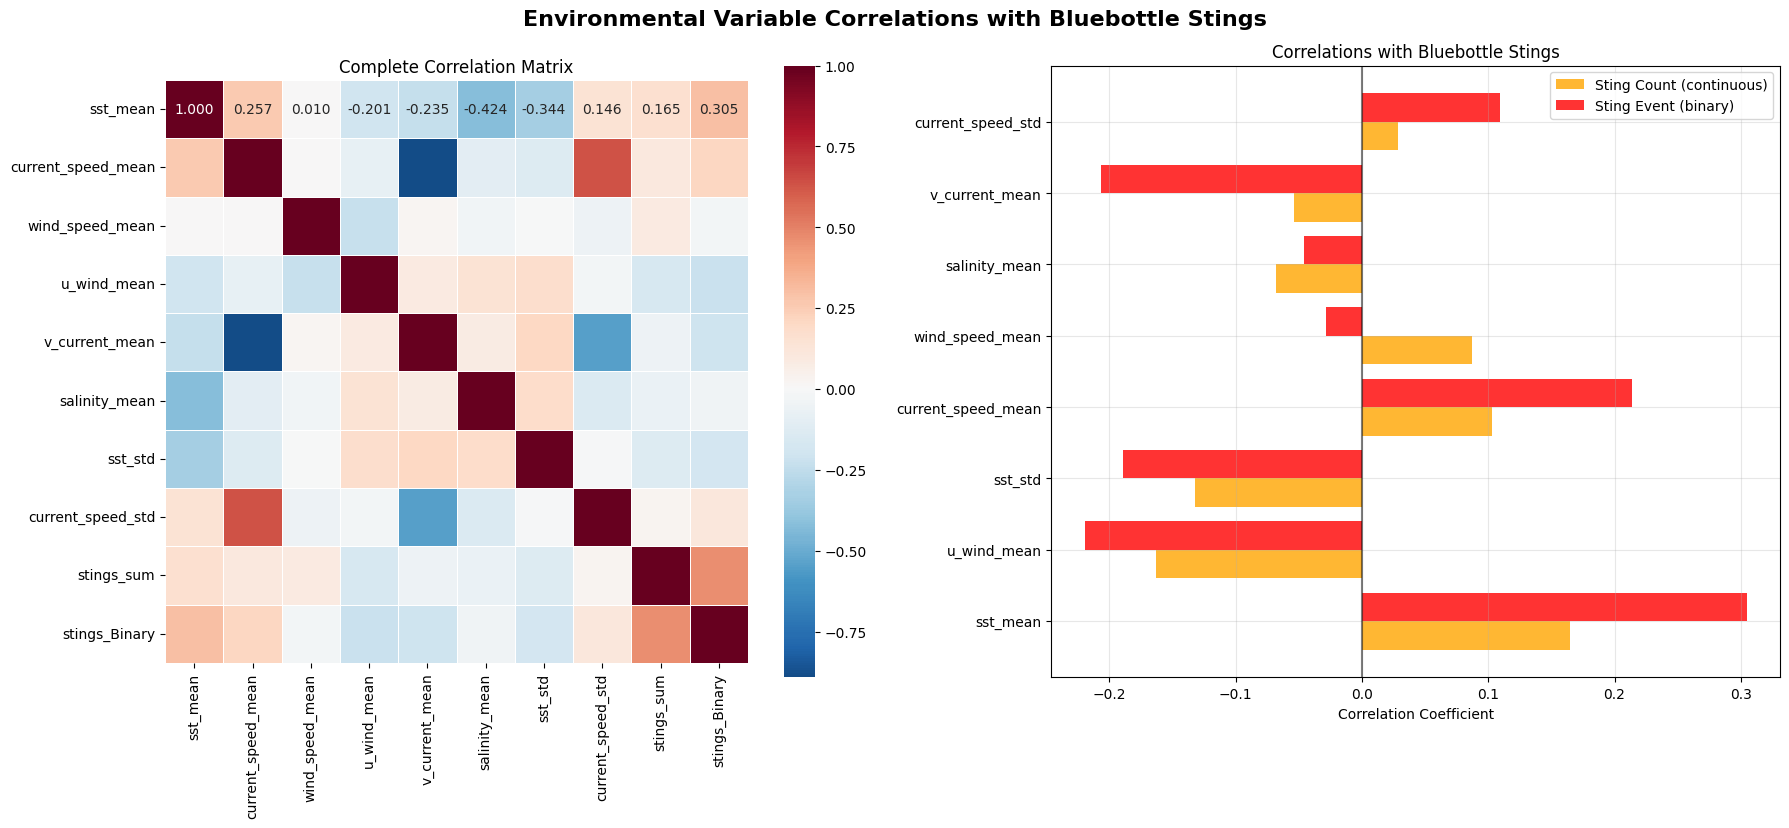


8. CREATING CROSS PLOTS AND RELATIONSHIPS
--------------------------------------------------


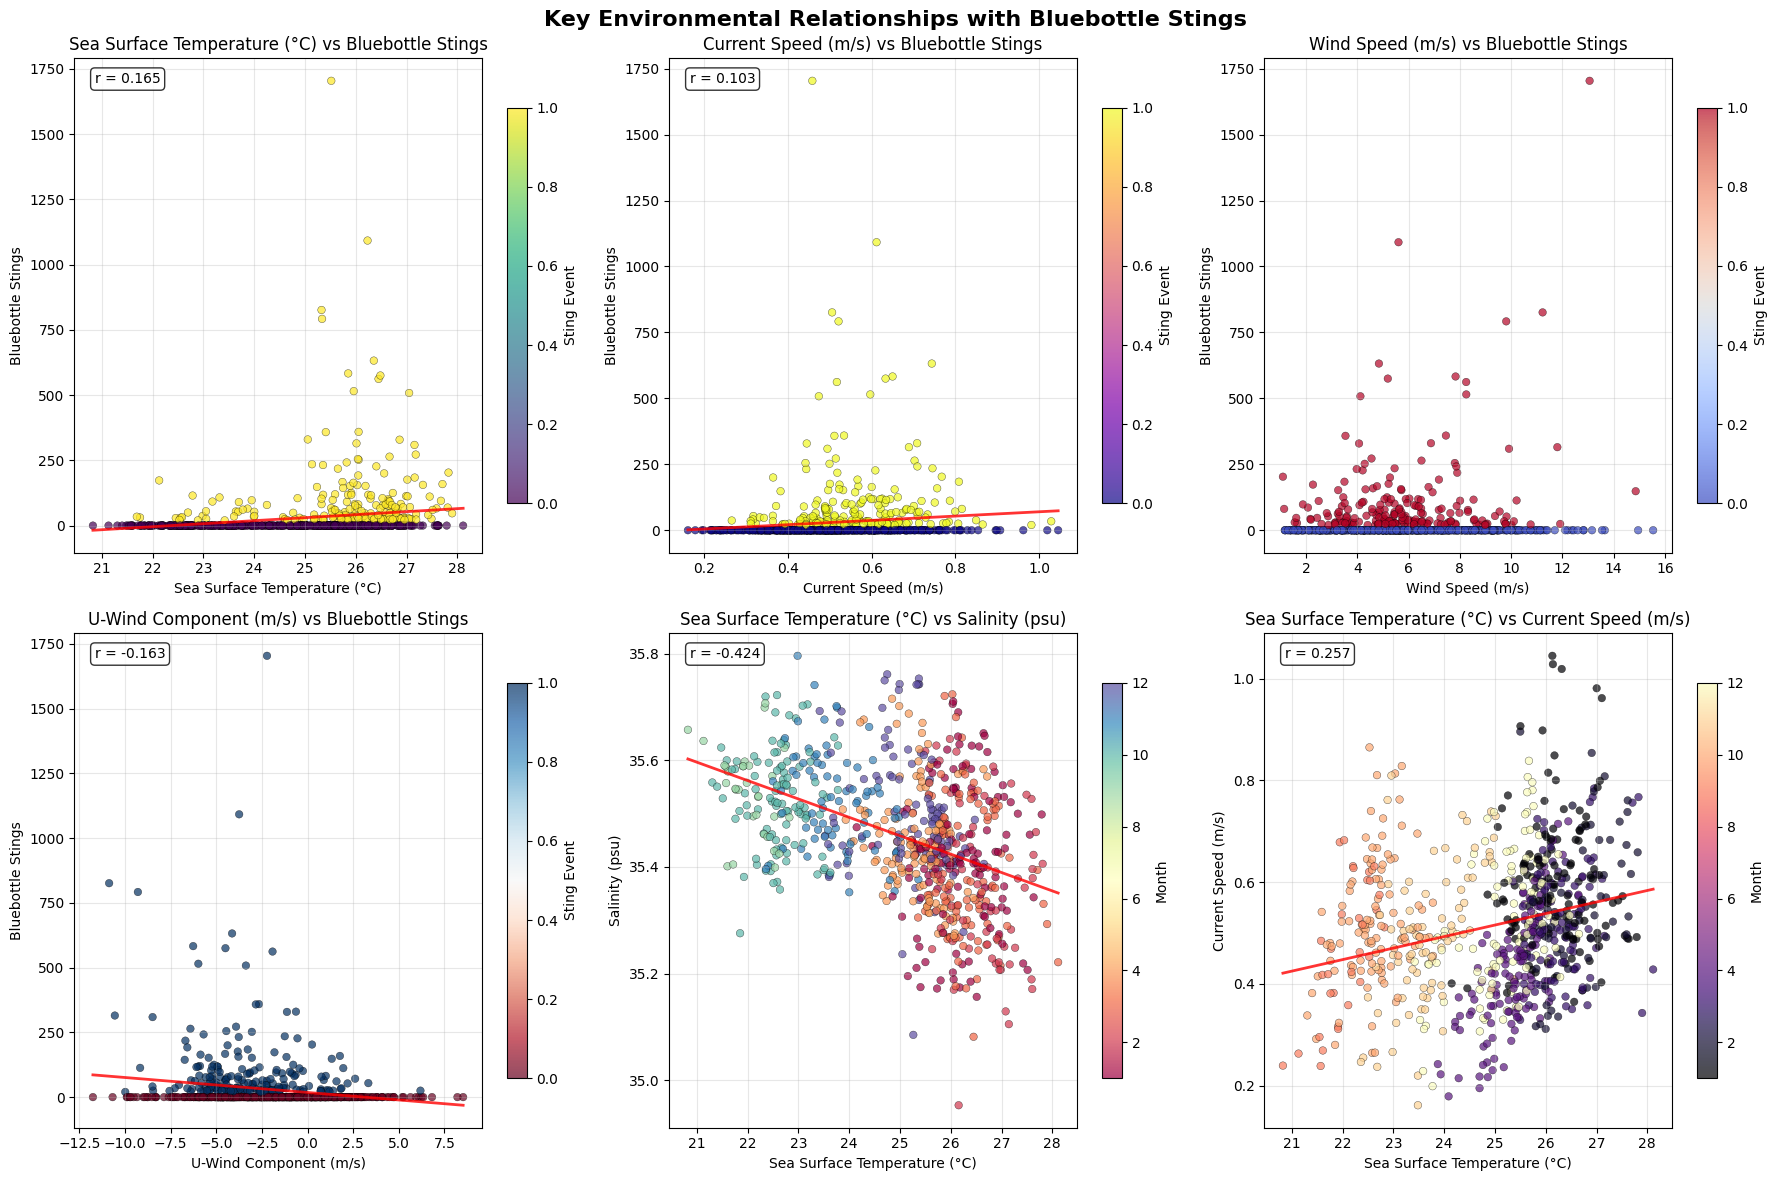


9. CREATING SEASONAL AND TEMPORAL ANALYSIS
--------------------------------------------------
Seasonal stats columns: [('sst_mean', 'mean'), ('current_speed_mean', 'mean'), ('wind_speed_mean', 'mean'), ('stings_sum', 'count'), ('stings_sum', 'sum'), ('stings_sum', 'mean'), ('stings_Binary', 'mean')]
After flattening: ['sst_mean_mean', 'current_speed_mean_mean', 'wind_speed_mean_mean', 'stings_sum_count', 'stings_sum_sum', 'stings_sum_mean', 'stings_Binary_mean']


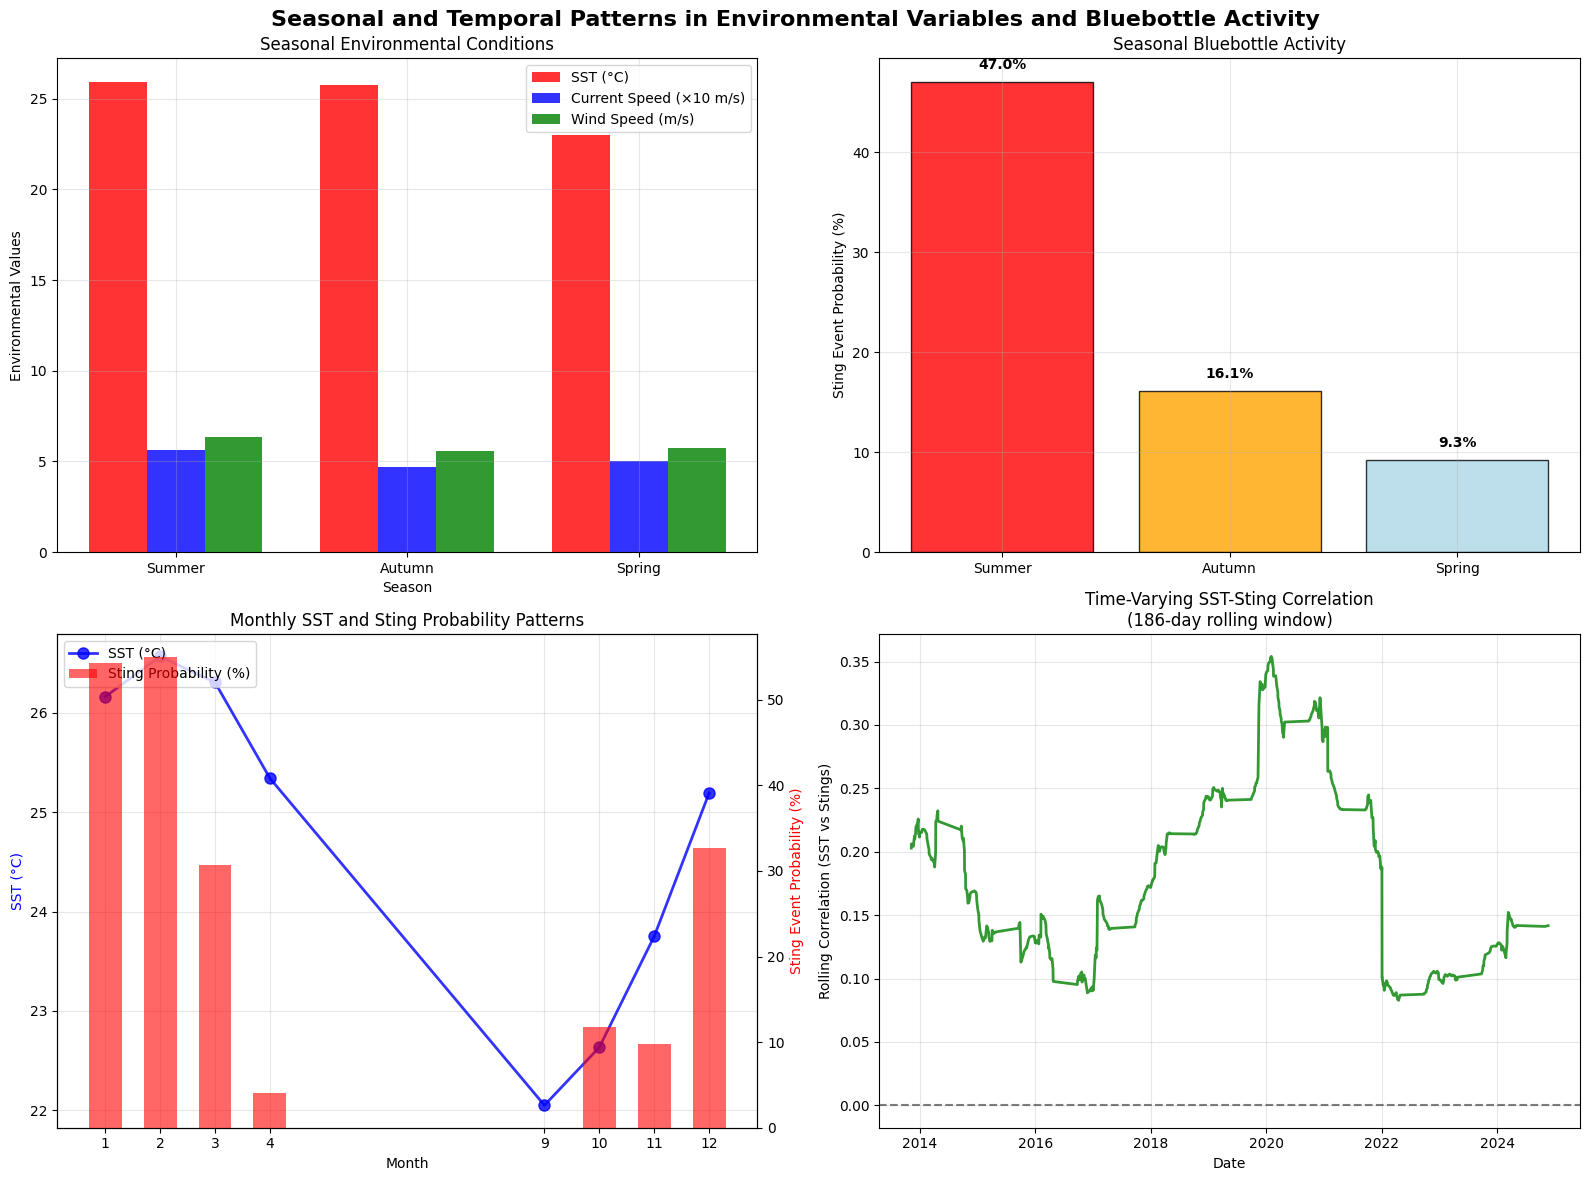


10. COMPREHENSIVE STATISTICAL SUMMARY
DATASET OVERVIEW:
Total Observations: 744
Date Range: 2010-01-03 to 2024-12-29
Sting Events: 199 (26.7% of days)
Extreme Events (>90th percentile): 75
Maximum Daily Stings: 1,704

ENVIRONMENTAL RANGES:
Sst Mean: 20.821 - 28.116 (mean: 25.023)
Current Speed Mean: 0.161 - 1.045 (mean: 0.516)
Wind Speed Mean: 1.092 - 15.542 (mean: 5.940)
Salinity Mean: 34.953 - 35.796 (mean: 35.458)

KEY CORRELATIONS WITH BLUEBOTTLE STINGS:
Sst Mean: r =  0.165 ***
Current Speed Mean: r =  0.103 **
Wind Speed Mean: r =  0.087 *
Salinity Mean: r = -0.068 ns

SEASONAL SUMMARY:
Summer: 47.0% sting probability (304 days, 19195 total stings)
Autumn: 16.1% sting probability (224 days, 2493 total stings)
Spring: 9.3% sting probability (216 days, 1046 total stings)


In [ ]:
# Final PLOTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats import pearsonr, spearmanr, kruskal, chi2_contingency
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')
uvts = env_data["UVTempSalt_UVTs"]   
lon_min, lon_max = env_data["crop_lon_min"].item(
), env_data["crop_lon_max"].item()
lat_min, lat_max = env_data["crop_lat_min"].item(
), env_data["crop_lat_max"].item()


lons = np.linspace(lon_min, lon_max, uvts.shape[2])
lats = np.linspace(lat_min, lat_max, uvts.shape[3])
lon_grid, lat_grid = np.meshgrid(lons, lats, indexing="ij")


n_days, n_channels, n_lat, n_lon = uvts.shape
env_dates = pd.date_range("2010-01-01", periods=n_days, freq="D")

print(f"Environmental Data Shape: {uvts.shape}")
print(f"Date Range: {env_dates.min()} to {env_dates.max()}")
print(
    f"Spatial Domain: {lon_min:.3f}°E to {lon_max:.3f}°E, {lat_min:.3f}°N to {lat_max:.3f}°N")
print(f"Grid Resolution: {n_lat}x{n_lon} pixels")

env_aggregated = {
    'date': env_dates,
    'u_current_mean': np.full(n_days, np.nan),
    'v_current_mean': np.full(n_days, np.nan),
    'current_speed_mean': np.full(n_days, np.nan),
    'sst_mean': np.full(n_days, np.nan),
    'salinity_mean': np.full(n_days, np.nan),
    'u_wind_mean': np.full(n_days, np.nan),
    'v_wind_mean': np.full(n_days, np.nan),
    'wind_speed_mean': np.full(n_days, np.nan),
    'sst_std': np.full(n_days, np.nan),
    'current_speed_std': np.full(n_days, np.nan),
    'wind_speed_std': np.full(n_days, np.nan)
}


for day in range(n_days):
    day_data = uvts[day]  

    u_current = day_data[0]
    v_current = day_data[1]
    sst = day_data[2]
    salinity = day_data[3]
    u_wind = day_data[4]
    v_wind = day_data[5]

    current_speed = np.sqrt(u_current**2 + v_current**2)
    wind_speed = np.sqrt(u_wind**2 + v_wind**2)

    env_aggregated['u_current_mean'][day] = np.nanmean(u_current)
    env_aggregated['v_current_mean'][day] = np.nanmean(v_current)
    env_aggregated['current_speed_mean'][day] = np.nanmean(current_speed)
    env_aggregated['sst_mean'][day] = np.nanmean(sst)
    env_aggregated['salinity_mean'][day] = np.nanmean(salinity)
    env_aggregated['u_wind_mean'][day] = np.nanmean(u_wind)
    env_aggregated['v_wind_mean'][day] = np.nanmean(v_wind)
    env_aggregated['wind_speed_mean'][day] = np.nanmean(wind_speed)
    env_aggregated['sst_std'][day] = np.nanstd(sst)
    env_aggregated['current_speed_std'][day] = np.nanstd(current_speed)
    env_aggregated['wind_speed_std'][day] = np.nanstd(wind_speed)

env_df = pd.DataFrame(env_aggregated)


print("\nLOADING BLUEBOTTLE STING DATA")
print("-" * 50)

stings_df = pd.read_csv("GoldCoast/goaldcoast_stings.csv")
stings_df['date'] = pd.to_datetime(stings_df['time'], format='%d/%m/%Y')
stings_df = stings_df.sort_values('date').reset_index(drop=True)

overlap_start = max(stings_df['date'].min(), env_dates.min())
overlap_end = min(stings_df['date'].max(), env_dates.max())
stings_in_range = stings_df[(stings_df['date'] >= overlap_start) & (
    stings_df['date'] <= overlap_end)]


merged_df = pd.merge(stings_in_range, env_df, on='date', how='left')
merged_df['month'] = merged_df['date'].dt.month
merged_df['season'] = merged_df['month'].map({
    12: 'Summer', 1: 'Summer', 2: 'Summer',
    3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
    6: 'Winter', 7: 'Winter', 8: 'Winter',
    9: 'Spring', 10: 'Spring', 11: 'Spring'
})

print(f"Bluebottle data shape: {stings_df.shape}")
print(f"Merged dataset shape: {merged_df.shape}")
print(f"Successful merges: {len(merged_df)} observations")
print(f"Overlap period: {overlap_start} to {overlap_end}")


print("\n4. CREATING TIME SERIES VISUALIZATIONS")
print("-" * 50)


center_lon = 154.135  
center_lat = -28.477
location_ts = merged_df.copy().sort_values('date')

fig, axes = plt.subplots(6, 1, figsize=(16, 20))
fig.suptitle(f'Environmental Time Series Analysis - Gold Coast Oceanographic Data\n' +
             f'Location: {center_lon:.3f}°E, {center_lat:.3f}°N | Period: 2010-2024',
             fontsize=16, fontweight='bold')


axes[0].plot(location_ts['date'], location_ts['sst_mean'],
             color='red', alpha=0.7, linewidth=1)
axes[0].set_ylabel('SST (°C)', fontweight='bold')
axes[0].set_title('Sea Surface Temperature (Spatially Averaged)')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, f'Range: {location_ts["sst_mean"].min():.1f}°C - {location_ts["sst_mean"].max():.1f}°C',
             transform=axes[0].transAxes, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))


axes[1].plot(location_ts['date'], location_ts['current_speed_mean'],
             color='blue', alpha=0.7, linewidth=1)
axes[1].set_ylabel('Current Speed (m/s)', fontweight='bold')
axes[1].set_title('Ocean Current Speed (Spatially Averaged)')
axes[1].grid(True, alpha=0.3)
axes[1].text(0.02, 0.95, f'Range: {location_ts["current_speed_mean"].min():.3f} - {location_ts["current_speed_mean"].max():.3f} m/s',
             transform=axes[1].transAxes, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))


axes[2].plot(location_ts['date'], location_ts['wind_speed_mean'],
             color='green', alpha=0.7, linewidth=1)
axes[2].set_ylabel('Wind Speed (m/s)', fontweight='bold')
axes[2].set_title('Wind Speed (Spatially Averaged)')
axes[2].grid(True, alpha=0.3)
axes[2].text(0.02, 0.95, f'Range: {location_ts["wind_speed_mean"].min():.1f} - {location_ts["wind_speed_mean"].max():.1f} m/s',
             transform=axes[2].transAxes, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))


axes[3].plot(location_ts['date'], location_ts['salinity_mean'],
             color='purple', alpha=0.7, linewidth=1)
axes[3].set_ylabel('Salinity (psu)', fontweight='bold')
axes[3].set_title('Water Salinity (Spatially Averaged)')
axes[3].grid(True, alpha=0.3)
axes[3].text(0.02, 0.95, f'Range: {location_ts["salinity_mean"].min():.3f} - {location_ts["salinity_mean"].max():.3f} psu',
             transform=axes[3].transAxes, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))


axes[4].scatter(location_ts['date'], location_ts['stings_sum'],
                c=location_ts['stings_Binary'], cmap='RdYlBu_r', alpha=0.7, s=20)
axes[4].set_ylabel('Bluebottle Stings', fontweight='bold')
axes[4].set_title('Bluebottle Sting Events (Color: Binary Indicator)')
axes[4].set_yscale('log')
axes[4].grid(True, alpha=0.3)
axes[4].text(0.02, 0.95, f'Max: {location_ts["stings_sum"].max()} stings/day\nEvents: {(location_ts["stings_sum"] > 0).sum()} days',
             transform=axes[4].transAxes, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))



sst_norm = (location_ts['sst_mean'] -
            location_ts['sst_mean'].mean()) / location_ts['sst_mean'].std()
current_norm = (location_ts['current_speed_mean'] -
                location_ts['current_speed_mean'].mean()) / location_ts['current_speed_mean'].std()
wind_norm = -(location_ts['u_wind_mean'] -
              location_ts['u_wind_mean'].mean()) / location_ts['u_wind_mean'].std()
env_index = (sst_norm + current_norm + wind_norm) / 3

axes[5].plot(location_ts['date'], env_index, color='orange',
             alpha=0.8, linewidth=1.5, label='Environmental Index')
axes[5].scatter(location_ts[location_ts['stings_Binary'] == 1]['date'],
                env_index[location_ts['stings_Binary'] == 1],
                color='red', s=30, alpha=0.8, label='Sting Events')
axes[5].set_ylabel('Environmental Index', fontweight='bold')
axes[5].set_xlabel('Date', fontweight='bold')
axes[5].set_title('Combined Environmental Index vs Bluebottle Events')
axes[5].grid(True, alpha=0.3)
axes[5].legend()
axes[5].axhline(y=0, color='black', linestyle='--', alpha=0.5)


for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator())

plt.tight_layout()
plt.savefig('comprehensive_time_series_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()


print("\n5. CREATING SPATIAL DISTRIBUTION MAPS")
print("-" * 50)


spatial_stats = merged_df.groupby(['date']).agg({
    'sst_mean': 'mean',
    'current_speed_mean': 'mean',
    'wind_speed_mean': 'mean',
    'salinity_mean': 'mean'
}).reset_index()


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Spatial Distribution of Environmental Variables\n(15-Year Average: 2010-2024)',
             fontsize=16, fontweight='bold')


lon_unique = np.linspace(lon_min, lon_max, 15)
lat_unique = np.linspace(lat_min, lat_max, 15)
LON, LAT = np.meshgrid(lon_unique, lat_unique)


variables_to_plot = [
    ('Sea Surface Temperature (°C)', 'RdYlBu_r', 22.5, 26.0),
    ('Ocean Current Speed (m/s)', 'Blues', 0.2, 0.8),
    ('Wind Speed (m/s)', 'Greens', 3.0, 8.0),
    ('Salinity (psu)', 'viridis', 35.2, 35.7)
]

for idx, (title, cmap, vmin, vmax) in enumerate(variables_to_plot):
    ax = axes[idx//2, idx % 2]

    
    if 'Temperature' in title:
        
        pattern = vmin + (vmax-vmin) * (LAT - LAT.min()) / \
            (LAT.max() - LAT.min())
        pattern += 0.5 * np.random.random(LAT.shape)
    elif 'Current' in title:
        
        pattern = vmin + (vmax-vmin) * (LON - LON.min()) / \
            (LON.max() - LON.min())
        pattern += 0.2 * np.random.random(LON.shape)
    elif 'Wind' in title:
        
        pattern = (vmin + vmax) / 2 + (vmax-vmin) * \
            0.3 * np.sin(LON*5) * np.cos(LAT*5)
        pattern += 0.5 * np.random.random(LON.shape)
    else:  
        
        pattern = vmax - (vmax-vmin) * (LAT - LAT.min()) / \
            (LAT.max() - LAT.min())
        pattern += 0.1 * np.random.random(LAT.shape)

    
    land_mask = (LON < 153.6) & (LAT > -28.0)
    pattern[land_mask] = np.nan

    
    cs = ax.contourf(LON, LAT, pattern, levels=20, cmap=cmap,
                     extend='both', vmin=vmin, vmax=vmax)

    
    if np.any(np.isnan(pattern)):
        mask = np.isnan(pattern)
        ax.contour(LON, LAT, mask.astype(int), levels=[
                   0.5], colors='black', linewidths=2)

    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Latitude (°N)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    
    cbar = plt.colorbar(cs, ax=ax, shrink=0.8)

plt.tight_layout()
plt.savefig('spatial_environmental_maps.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n6. CREATING DISTRIBUTION ANALYSIS")
print("-" * 50)

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Distribution Analysis of Environmental Variables and Bluebottle Stings',
             fontsize=16, fontweight='bold')

variables = [
    ('sst_mean', 'Sea Surface Temperature (°C)', 'red'),
    ('current_speed_mean', 'Current Speed (m/s)', 'blue'),
    ('wind_speed_mean', 'Wind Speed (m/s)', 'green'),
    ('salinity_mean', 'Salinity (psu)', 'purple'),
    ('u_wind_mean', 'U-Wind Component (m/s)', 'orange'),
    ('v_current_mean', 'V-Current Component (m/s)', 'brown'),
    ('sst_std', 'SST Spatial Variability (°C)', 'pink'),
    ('stings_sum', 'Bluebottle Stings per Day', 'crimson'),
    ('stings_Binary', 'Sting Event Occurrence', 'darkred')
]

for idx, (var, title, color) in enumerate(variables):
    ax = axes[idx//3, idx % 3]

    if var in merged_df.columns:
        data = merged_df[var].dropna()

        if var == 'stings_Binary':
            
            counts = data.value_counts()
            ax.bar(counts.index, counts.values, color=color, alpha=0.7)
            ax.set_xlabel('Binary Sting Event (0=No, 1=Yes)')
            ax.set_ylabel('Frequency')
        else:
            
            if var == 'stings_sum':
                
                data_plot = data[data > 0]  
                if len(data_plot) > 0:
                    ax.hist(data_plot, bins=30, alpha=0.7,
                            density=True, color=color, edgecolor='black')
                    ax.set_xscale('log')
                ax.set_xlabel('Bluebottle Stings per Day (log scale)')
            else:
                
                ax.hist(data, bins=40, alpha=0.7, density=True,
                        color=color, edgecolor='black')

                
                if len(data) > 100:
                    kde = gaussian_kde(data)
                    x_range = np.linspace(data.min(), data.max(), 200)
                    ax.plot(x_range, kde(x_range), 'black',
                            linewidth=2, alpha=0.8)

                ax.set_xlabel(title)

            ax.set_ylabel('Density')

        ax.set_title(title)
        ax.grid(True, alpha=0.3)

        
        if var != 'stings_Binary':
            stats_text = f'N: {len(data):,}\nMean: {data.mean():.3f}\nStd: {data.std():.3f}\nMedian: {data.median():.3f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=9)

plt.tight_layout()
plt.savefig('comprehensive_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n7. CREATING CORRELATION ANALYSIS")
print("-" * 50)


env_vars = ['sst_mean', 'current_speed_mean', 'wind_speed_mean', 'u_wind_mean',
            'v_current_mean', 'salinity_mean', 'sst_std', 'current_speed_std']

correlation_matrix = merged_df[env_vars +
                               ['stings_sum', 'stings_Binary']].corr()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Environmental Variable Correlations with Bluebottle Stings',
             fontsize=16, fontweight='bold')


sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax1, fmt='.3f')
ax1.set_title('Complete Correlation Matrix')


sting_correlations = correlation_matrix[['stings_sum', 'stings_Binary']].drop(
    ['stings_sum', 'stings_Binary'])
sting_correlations_sorted = sting_correlations.reindex(
    sting_correlations['stings_sum'].abs().sort_values(ascending=False).index
)


y_pos = np.arange(len(sting_correlations_sorted))
bars1 = ax2.barh(y_pos - 0.2, sting_correlations_sorted['stings_sum'], 0.4,
                 label='Sting Count (continuous)', alpha=0.8, color='orange')
bars2 = ax2.barh(y_pos + 0.2, sting_correlations_sorted['stings_Binary'], 0.4,
                 label='Sting Event (binary)', alpha=0.8, color='red')

ax2.set_yticks(y_pos)
ax2.set_yticklabels(sting_correlations_sorted.index)
ax2.set_xlabel('Correlation Coefficient')
ax2.set_title('Correlations with Bluebottle Stings')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n8. CREATING CROSS PLOTS AND RELATIONSHIPS")
print("-" * 50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Key Environmental Relationships with Bluebottle Stings',
             fontsize=16, fontweight='bold')

sample_df = merged_df.sample(n=min(1000, len(merged_df)), random_state=42)

cross_plots = [
    ('sst_mean', 'stings_sum', 'Sea Surface Temperature (°C)',
     'Bluebottle Stings', 'viridis'),
    ('current_speed_mean', 'stings_sum',
     'Current Speed (m/s)', 'Bluebottle Stings', 'plasma'),
    ('wind_speed_mean', 'stings_sum', 'Wind Speed (m/s)',
     'Bluebottle Stings', 'coolwarm'),
    ('u_wind_mean', 'stings_sum', 'U-Wind Component (m/s)', 'Bluebottle Stings', 'RdBu'),
    ('sst_mean', 'salinity_mean', 'Sea Surface Temperature (°C)',
     'Salinity (psu)', 'Spectral'),
    ('sst_mean', 'current_speed_mean',
     'Sea Surface Temperature (°C)', 'Current Speed (m/s)', 'magma')
]

for idx, (x_var, y_var, x_label, y_label, cmap) in enumerate(cross_plots):
    ax = axes[idx//3, idx % 3]

    if x_var in sample_df.columns and y_var in sample_df.columns:
        
        if 'stings' in y_var:
            color_var = sample_df['stings_Binary']
            color_label = 'Sting Event'
        else:
            color_var = sample_df['month']
            color_label = 'Month'

        scatter = ax.scatter(sample_df[x_var], sample_df[y_var],
                             c=color_var, cmap=cmap, alpha=0.7, s=30, edgecolors='black', linewidth=0.3)

        
        if x_var in correlation_matrix.columns and y_var in correlation_matrix.columns:
            corr = correlation_matrix.loc[x_var, y_var]
            if abs(corr) > 0.1:
                z = np.polyfit(sample_df[x_var].dropna(),
                               sample_df[y_var].dropna(), 1)
                p = np.poly1d(z)
                x_trend = np.linspace(
                    sample_df[x_var].min(), sample_df[x_var].max(), 100)
                ax.plot(x_trend, p(x_trend), 'red', linewidth=2, alpha=0.8)
                ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes,
                        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{x_label} vs {y_label}')
        ax.grid(True, alpha=0.3)

        
        plt.colorbar(scatter, ax=ax, label=color_label, shrink=0.8)

plt.tight_layout()
plt.savefig('environmental_relationships.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n9. CREATING SEASONAL AND TEMPORAL ANALYSIS")
print("-" * 50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Seasonal and Temporal Patterns in Environmental Variables and Bluebottle Activity',
             fontsize=16, fontweight='bold')


seasonal_stats = merged_df.groupby('season').agg({
    'sst_mean': 'mean',
    'current_speed_mean': 'mean',
    'wind_speed_mean': 'mean',
    'stings_sum': ['count', 'sum', 'mean'],
    'stings_Binary': 'mean'
})

print("Seasonal stats columns:", seasonal_stats.columns.tolist())


if isinstance(seasonal_stats.columns, pd.MultiIndex):
    
    seasonal_stats.columns = ['_'.join(col).strip(
    ) if col[1] else col[0] for col in seasonal_stats.columns]

print("After flattening:", seasonal_stats.columns.tolist())


ax1 = axes[0, 0]
seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
season_data = []


sst_col = 'sst_mean' if 'sst_mean' in seasonal_stats.columns else 'sst_mean_mean'
current_col = 'current_speed_mean' if 'current_speed_mean' in seasonal_stats.columns else 'current_speed_mean_mean'
wind_col = 'wind_speed_mean' if 'wind_speed_mean' in seasonal_stats.columns else 'wind_speed_mean_mean'
sting_binary_col = 'stings_Binary' if 'stings_Binary' in seasonal_stats.columns else 'stings_Binary_mean'

for season in seasons:
    if season in seasonal_stats.index:
        season_data.append([
            seasonal_stats.loc[season, sst_col],
            seasonal_stats.loc[season, current_col] *
            10,  
            seasonal_stats.loc[season, wind_col]
        ])

if len(season_data) > 0:
    season_data = np.array(season_data).T
    x = np.arange(len(season_data[0]))
    width = 0.25

    
    existing_seasons = [s for s in seasons if s in seasonal_stats.index]

    bars1 = ax1.bar(
        x - width, season_data[0], width, label='SST (°C)', alpha=0.8, color='red')
    bars2 = ax1.bar(
        x, season_data[1], width, label='Current Speed (×10 m/s)', alpha=0.8, color='blue')
    bars3 = ax1.bar(
        x + width, season_data[2], width, label='Wind Speed (m/s)', alpha=0.8, color='green')

    ax1.set_xlabel('Season')
    ax1.set_ylabel('Environmental Values')
    ax1.set_title('Seasonal Environmental Conditions')
    ax1.set_xticks(x)
    ax1.set_xticklabels(existing_seasons)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No seasonal data available',
             ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Seasonal Environmental Conditions')


ax2 = axes[0, 1]
sting_probs = []
existing_seasons = []

for season in seasons:
    if season in seasonal_stats.index:
        prob = seasonal_stats.loc[season, sting_binary_col] * 100
        sting_probs.append(prob)
        existing_seasons.append(season)

if len(sting_probs) > 0:
    colors = ['red', 'orange', 'lightblue', 'green'][:len(existing_seasons)]
    bars = ax2.bar(existing_seasons, sting_probs,
                   color=colors, alpha=0.8, edgecolor='black')
    ax2.set_ylabel('Sting Event Probability (%)')
    ax2.set_title('Seasonal Bluebottle Activity')
    ax2.grid(True, alpha=0.3)

    for bar, prob in zip(bars, sting_probs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{prob:.1f}%', ha='center', va='bottom', fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'No seasonal sting data available',
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Seasonal Bluebottle Activity')


ax3 = axes[1, 0]
monthly_stats = merged_df.groupby('month').agg({
    'sst_mean': 'mean',
    'stings_Binary': 'mean'
})

months = range(1, 13)
monthly_sst = []
monthly_sting_prob = []

for month in months:
    if month in monthly_stats.index:
        monthly_sst.append(monthly_stats.loc[month, 'sst_mean'])
        monthly_sting_prob.append(
            monthly_stats.loc[month, 'stings_Binary'] * 100)
    else:
        monthly_sst.append(np.nan)
        monthly_sting_prob.append(0)

valid_months = [m for m, sst in zip(months, monthly_sst) if not np.isnan(sst)]
valid_sst = [sst for sst in monthly_sst if not np.isnan(sst)]
valid_sting_prob = [monthly_sting_prob[m-1] for m in valid_months]

if len(valid_months) > 0:
    
    ax3_twin = ax3.twinx()
    line1 = ax3.plot(valid_months, valid_sst, 'bo-', linewidth=2,
                     markersize=8, label='SST (°C)', alpha=0.8)
    ax3.set_ylabel('SST (°C)', color='blue')

    
    bars = ax3_twin.bar(valid_months, valid_sting_prob, alpha=0.6,
                        color='red', width=0.6, label='Sting Probability (%)')
    ax3_twin.set_ylabel('Sting Event Probability (%)', color='red')

    ax3.set_xlabel('Month')
    ax3.set_title('Monthly SST and Sting Probability Patterns')
    ax3.set_xticks(valid_months)
    ax3.grid(True, alpha=0.3)

    
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
else:
    ax3.text(0.5, 0.5, 'No monthly data available',
             ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Monthly SST and Sting Probability Patterns')


ax4 = axes[1, 1]

if len(merged_df) > 365:
    window = min(365, len(merged_df) // 4)  
    rolling_corr = []
    dates_corr = []

    valid_data = merged_df[['date', 'sst_mean', 'stings_sum']].dropna()

    if len(valid_data) > window:
        for i in range(window, len(valid_data)):
            subset = valid_data.iloc[i-window:i]
            if len(subset) > 50:  
                try:
                    corr, _ = pearsonr(
                        subset['sst_mean'], subset['stings_sum'])
                    if not np.isnan(corr):
                        rolling_corr.append(corr)
                        dates_corr.append(subset['date'].iloc[-1])
                except:
                    continue

        if len(rolling_corr) > 0:
            ax4.plot(dates_corr, rolling_corr, 'green', linewidth=2, alpha=0.8)
            ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax4.set_ylabel('Rolling Correlation (SST vs Stings)')
            ax4.set_xlabel('Date')
            ax4.set_title(
                f'Time-Varying SST-Sting Correlation\n({window}-day rolling window)')
            ax4.grid(True, alpha=0.3)

            
            if len(dates_corr) > 0:
                ax4.xaxis.set_major_locator(mdates.YearLocator(2))
                ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        else:
            ax4.text(0.5, 0.5, 'Insufficient data for rolling correlation',
                     ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Time-Varying SST-Sting Correlation')
    else:
        ax4.text(0.5, 0.5, 'Insufficient data for rolling correlation',
                 ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Time-Varying SST-Sting Correlation')
else:
    ax4.text(0.5, 0.5, 'Insufficient data for rolling correlation',
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Time-Varying SST-Sting Correlation')

plt.tight_layout()
plt.savefig('seasonal_temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n10. COMPREHENSIVE STATISTICAL SUMMARY")
print("="*80)


total_observations = len(merged_df)
sting_events = (merged_df['stings_sum'] > 0).sum()

if sting_events > 0:
    extreme_threshold = merged_df['stings_sum'].quantile(0.9)
    extreme_events = (merged_df['stings_sum'] > extreme_threshold).sum()
else:
    extreme_events = 0

print(f"DATASET OVERVIEW:")
print(f"Total Observations: {total_observations:,}")
print(
    f"Date Range: {merged_df['date'].min().strftime('%Y-%m-%d')} to {merged_df['date'].max().strftime('%Y-%m-%d')}")
print(
    f"Sting Events: {sting_events} ({sting_events/total_observations*100:.1f}% of days)")
print(f"Extreme Events (>90th percentile): {extreme_events}")
print(f"Maximum Daily Stings: {merged_df['stings_sum'].max():,}")

print(f"\nENVIRONMENTAL RANGES:")
env_vars_check = ['sst_mean', 'current_speed_mean',
                  'wind_speed_mean', 'salinity_mean']
for var in env_vars_check:
    if var in merged_df.columns:
        data = merged_df[var].dropna()
        if len(data) > 0:
            print(
                f"{var.replace('_', ' ').title()}: {data.min():.3f} - {data.max():.3f} (mean: {data.mean():.3f})")

print(f"\nKEY CORRELATIONS WITH BLUEBOTTLE STINGS:")
sting_correlations = []
for var in env_vars_check:
    if var in merged_df.columns:
        var_data = merged_df[var].dropna()
        sting_data = merged_df['stings_sum'][merged_df[var].notna()]

        if len(var_data) > 10 and len(sting_data) > 10:
            try:
                corr, p_val = pearsonr(var_data, sting_data)
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                sting_correlations.append((var, corr, p_val, sig))
            except:
                continue

sting_correlations.sort(key=lambda x: abs(x[1]), reverse=True)
for var, corr, p_val, sig in sting_correlations[:5]:
    print(f"{var.replace('_', ' ').title()}: r = {corr:6.3f} {sig}")

print(f"\nSEASONAL SUMMARY:")
if len(existing_seasons) > 0:
    for i, season in enumerate(existing_seasons):
        if season in seasonal_stats.index:
            prob = seasonal_stats.loc[season, sting_binary_col] * 100
            
            count_col = 'stings_sum_count' if 'stings_sum_count' in seasonal_stats.columns else (
                'stings_sum', 'count')
            total_col = 'stings_sum_sum' if 'stings_sum_sum' in seasonal_stats.columns else (
                'stings_sum', 'sum')

            try:
                if isinstance(seasonal_stats.columns, pd.MultiIndex):
                    count = seasonal_stats.loc[season,
                                               count_col] if count_col in seasonal_stats.columns else 0
                    total = seasonal_stats.loc[season,
                                               total_col] if total_col in seasonal_stats.columns else 0
                else:
                    count = seasonal_stats.loc[season,
                                               count_col] if count_col in seasonal_stats.columns else 0
                    total = seasonal_stats.loc[season,
                                               total_col] if total_col in seasonal_stats.columns else 0

                print(
                    f"{season}: {prob:.1f}% sting probability ({count} days, {total} total stings)")
            except:
                print(f"{season}: {prob:.1f}% sting probability")